In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append(os.path.abspath('src'))

### <span style="color: lightskyblue;"> Carga de datos </span>

In [3]:
import pandas as pd
 
dtypes = {
    'id_recorrido': 'string',
    'duracion_recorrido': 'int32',
    'id_estacion_origen': 'string',
    'nombre_estacion_origen': 'string',
    'direccion_estacion_origen': 'string',
    'long_estacion_origen': 'float32',
    'lat_estacion_origen': 'float32',
    'id_estacion_destino': 'string',  # puede tener NaN → usar float
    'nombre_estacion_destino': 'string',
    'direccion_estacion_destino': 'string',
    'long_estacion_destino': 'float32',
    'lat_estacion_destino': 'float32',
    'id_usuario': 'string',  # puede tener decimales o NaN
    'modelo_bicicleta': 'string',
    'genero': 'string'
}

dfs = []

for path, drop_cols, rename_cols in tqdm(archivos, desc="Procesando archivos"):
    df = clean_and_load(path, drop_cols=drop_cols, rename_cols=rename_cols)
    dfs.append(df)

    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')

    if rename_cols:
        df = df.rename(columns=rename_cols)

    df.columns = [col.lower().replace('é', 'e').replace('É', 'E') for col in df.columns]

    if 'duracion_recorrido' in df.columns:
        df['duracion_recorrido'] = (
            df['duracion_recorrido']
            .astype(str)
            .str.replace(',', '', regex=False)
        )

    import numpy as np

    for pair in [('lat_estacion_origen', 'long_estacion_origen'),
                 ('lat_estacion_destino', 'long_estacion_destino')]:
        
        col_lat, col_long = pair
        if col_lat in df.columns and df[col_lat].astype(str).str.contains(',', regex=False).any():
            split_coords = df[col_lat].astype(str).str.split(',', expand=True)
            df[col_lat] = split_coords[0]
            df[col_long] = split_coords[1] if col_long in df.columns else np.nan

    for col in ['lat_estacion_origen', 'long_estacion_origen', 'lat_estacion_destino', 'long_estacion_destino']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

    df = df.astype({k: v for k, v in dtypes.items() if k in df.columns})

    df = df[[col for col in final_columns if col in df.columns]]
    df = df.loc[:, ~df.columns.duplicated()]

    if 'género' in df.columns and 'genero' in df.columns:
        df['genero'] = df['genero'].fillna(df['género'])
        df = df.drop(columns=['género'])

    df['id_estacion_origen'] = df['id_estacion_origen'].str.replace('BAEcobici', '', regex=False)
    df['id_estacion_destino'] = df['id_estacion_destino'].str.replace('BAEcobici', '', regex=False)
    df['id_recorrido'] = df['id_recorrido'].str.replace('BAEcobici', '', regex=False)
    df['id_usuario'] = df['id_usuario'].str.replace('BAEcobici', '', regex=False)

    if 'duracion_recorrido' in df.columns:
        df['duracion_recorrido'] = pd.to_numeric(df['duracion_recorrido'], errors='coerce')
        df = df[df['duracion_recorrido'] >= 60]

    # delete all rows where id_estacion_origen is NaN
    df = df[df['id_estacion_origen'].notna()]

    return df


trips_2020 = clean_and_load('data/raw/trips_2020.csv', drop_cols=['Unnamed: 0'])
trips_2021 = clean_and_load('data/raw/trips_2021.csv', drop_cols=['Unnamed: 0', 'genero'])  # eliminar segunda 'Género'
trips_2022 = clean_and_load('data/raw/trips_2022.csv', drop_cols=['Unnamed: 0', 'X'], rename_cols={'Género': 'genero'})
trips_2023 = clean_and_load('data/raw/trips_2023.csv', drop_cols=['Unnamed: 0'])
trips_2024 = clean_and_load('data/raw/trips_2024.csv')

trips_2024_filtered = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month <= 8]
trips_2024_test = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month >= 9]

trips = pd.concat([trips_2020, trips_2021, trips_2022, trips_2023, trips_2024_filtered], ignore_index=True)

trips.to_csv('data/processed/trips.csv', index=False)
trips_2024_test.to_csv('data/processed/trips_test.csv', index=False)


KeyboardInterrupt: 

In [ ]:

import pandas as pd

# Lista de archivos y si contienen o no la columna del DNI
user_files = [
    ('data/raw/usuarios_ecobici_2020.csv', True),
    ('data/raw/usuarios_ecobici_2021.csv', True),
    ('data/raw/usuarios_ecobici_2022.csv', True),
    ('data/raw/usuarios_ecobici_2023.csv', True),
    ('data/raw/usuarios_ecobici_2024.csv', False),  # este no tiene columna de DNI
]

user_dfs = []

for path, has_dni in user_files:
    df = pd.read_csv(path, parse_dates=['fecha_alta'])
    if has_dni:
        df.drop(columns=['Customer.Has.Dni..Yes...No.'], inplace=True)
    # Normalizar nombres de columnas
    df.columns = df.columns.str.lower().str.replace('.', '_').str.replace(' ', '').str.replace('__', '_')
    df = df.rename(columns={
        'id_usuario': 'id_usuario',
        'genero_usuario': 'genero_usuario',
        'edad_usuario': 'edad_usuario',
        'fecha_alta': 'fecha_alta',
        'hora_alta': 'hora_alta',
    })

    user_dfs.append(df)

# Concatenar todos los usuarios
usuarios = pd.concat(user_dfs, ignore_index=True)

# Convertir id_usuario a string para hacer merge correcto
usuarios['id_usuario'] = usuarios['id_usuario'].astype(float)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_31512\2079243983.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=['fecha_alta'])


In [ ]:
# Nos aseguramos que los id_usuario de trips también sean string
trips = pd.read_csv('data/processed/trips.csv')
trips['id_usuario'] = trips['id_usuario'].astype(float)
# usuarios edad entre 10 y 100
# Paso 1: Convertir todo a string
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(str)

# Paso 2: Eliminar comas, espacios y valores vacíos
usuarios['edad_usuario'] = usuarios['edad_usuario'].str.replace(',', '', regex=False).str.strip()

# Paso 3: Filtrar solo los valores que son dígitos (descarta "NaN", "dos mil", etc.)
usuarios = usuarios[usuarios['edad_usuario'].str.isdigit()]

# Paso 4: Convertir a int
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(int)

# Paso 5: Filtrar valores fuera del rango 10–100
usuarios = usuarios[(usuarios['edad_usuario'] >= 10) & (usuarios['edad_usuario'] <= 100)]



# Hacemos un left join: cada recorrido se enriquece con datos del usuario
trips_enriched = trips.merge(
    usuarios[['id_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']],
    on='id_usuario',
    how='left'
)

# df = df.groupby("nombre_estacion_origen").filter(
#     lambda x: x["direccion_estacion_origen"].nunique() > 1
# )
usuarios

C:\Users\Matteo\AppData\Local\Temp\ipykernel_31512\2560489067.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv('data/processed/trips.csv')


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,735944.0,FEMALE,29,2020-12-31,20:19:04
1,735892.0,MALE,44,2020-12-31,11:24:04
2,735873.0,MALE,39,2020-12-31,09:28:27
3,735876.0,MALE,37,2020-12-31,09:49:30
4,735952.0,OTHER,29,2020-12-31,21:07:04
...,...,...,...,...,...
627876,1120417.0,FEMALE,45,2024-03-01,15:09:21
627877,1153589.0,MALE,55,2024-05-08,18:17:14
627878,1216661.0,MALE,25,2024-09-28,09:23:29
627879,1256657.0,MALE,24,2024-11-22,19:38:23


In [ ]:
trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)


In [4]:
import pandas as pd

# Filtro por mes específico (ej: agosto → 8)
def filtrar_por_mes(df, mes, columna='fecha_origen_recorrido'):
    return df[df[columna].dt.month == mes]

# Filtro por múltiples meses (ej: verano → diciembre, enero, febrero)
def filtrar_por_meses(df, meses, columna='fecha_origen_recorrido'):
    return df[df[columna].dt.month.isin(meses)]

# Filtro por año específico
def filtrar_por_ano(df, ano, columna='fecha_origen_recorrido'):
    return df[df[columna].dt.year == ano]

# Filtro por rango de fechas
def filtrar_por_rango_fecha(df, fecha_inicio, fecha_fin, columna='fecha_origen_recorrido'):
    return df[(df[columna] >= fecha_inicio) & (df[columna] <= fecha_fin)]


In [4]:
import pandas as pd

# que el dataset se quede solo con los meses diciembre, enero y febrero]
trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
trips_verano = trips_enriched[trips_enriched['fecha_origen_recorrido'].dt.month.isin([12, 1, 2]) & trips_enriched['fecha_destino_recorrido'].dt.month.isin([12, 1, 2])]
trips_verano.to_csv('data/processed/trips_verano.csv', index=False)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_5860\3433263776.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')


## <span style="color: lightskyblue;"> 2. Transformación a Series Temporales (30 min) </span>

In [5]:
import pandas as pd
import numpy as np
from datetime import timedelta

def create_time_series_dataset_fast(trips_df, time_window_minutes=30):
    """
    Versión optimizada de transformación de dataset de viajes a series temporales.
    """
    trips_df = trips_df.copy()

    trips_df['fecha_origen_recorrido'] = pd.to_datetime(trips_df['fecha_origen_recorrido'])
    trips_df['fecha_destino_recorrido'] = pd.to_datetime(trips_df['fecha_destino_recorrido'])
    
    # 1. Crear columnas de ventana para despachos (origen) y arribos (destino)
    # trips_df['timestamp_origen_window'] = trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T')
    trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))

    trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
    trips_df['timestamp_destino_prev'] = (
    trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
    arribos_prev = trips_df.groupby(['timestamp_destino_prev','id_estacion_destino']).size().reset_index(name='arribos_prev_count').rename(columns={'timestamp_destino_prev':'timestamp','id_estacion_destino':'id_estacion'})

    # 2. Obtener rango de timestamps
    fecha_min = trips_df['timestamp_origen_window'].min()
    fecha_max = trips_df['timestamp_destino_window'].max()
    timestamps = pd.date_range(start=fecha_min, end=fecha_max, freq=f'{time_window_minutes}T')
    
    # 3. Obtener lista única de estaciones (origen + destino)
    estaciones_origen = trips_df[['id_estacion_origen', 'nombre_estacion_origen',
                                  'direccion_estacion_origen', 'lat_estacion_origen',
                                  'long_estacion_origen']].drop_duplicates()
    estaciones_destino = trips_df[['id_estacion_destino', 'nombre_estacion_destino',
                                   'direccion_estacion_destino', 'lat_estacion_destino',
                                   'long_estacion_destino']].drop_duplicates()

    estaciones_origen.columns = ['id_estacion', 'nombre_estacion', 'direccion_estacion', 'lat_estacion', 'long_estacion']
    estaciones_destino.columns = ['id_estacion', 'nombre_estacion', 'direccion_estacion', 'lat_estacion', 'long_estacion']
    
    estaciones = pd.concat([estaciones_origen, estaciones_destino]).drop_duplicates(subset=['id_estacion']).dropna(subset=['id_estacion'])

    print(f"Total de timestamps: {len(timestamps)}")
    print(f"Total de estaciones: {len(estaciones)}")
    
    # 4. Crear esqueleto base con producto cartesiano entre timestamps y estaciones
    timestamps_df = pd.DataFrame({'timestamp': timestamps})
    ts_grid = timestamps_df.assign(key=1).merge(estaciones.assign(key=1), on='key').drop(columns='key')

    # 5. Precalcular estadísticas históricas (ventana de despachos)
    despachos = trips_df.groupby(['timestamp_origen_window', 'id_estacion_origen']).agg(
        despachos_count=('id_estacion_origen', 'count'),
        duracion_recorrido_mean=('duracion_recorrido', 'mean'),
        duracion_recorrido_std=('duracion_recorrido', 'std'),
        duracion_recorrido_count=('duracion_recorrido', 'count'),
        edad_usuario_mean=('edad_usuario', 'mean'),
        edad_usuario_std=('edad_usuario', 'std'),
        proporcion_mujeres=('genero', lambda x: (x == 'F').sum() / len(x) if len(x) > 0 else 0),
        modelo_mas_comun=('modelo_bicicleta', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'UNKNOWN')
    ).reset_index()

    despachos = despachos.rename(columns={
        'timestamp_origen_window': 'timestamp',
        'id_estacion_origen': 'id_estacion'
    })

    # 6. Precalcular arribos (ventana futura)
    arribos = trips_df.groupby(['timestamp_destino_window', 'id_estacion_destino']).size().reset_index(name='arribos_count')
    arribos = arribos.rename(columns={
        'timestamp_destino_window': 'timestamp',
        'id_estacion_destino': 'id_estacion'
    })

    # 7. Merge de todas las features al grid base
    ts_df = ts_grid.merge(despachos, on=['timestamp', 'id_estacion'], how='left')
    ts_df = ts_df.merge(arribos, on=['timestamp', 'id_estacion'], how='left')
    ts_df = ts_df.merge(arribos_prev, on=['timestamp','id_estacion'], how='left')
    ts_df['arribos_prev_count'] = ts_df['arribos_prev_count'].fillna(0).astype(int)

    # 8. Rellenar NaNs con valores por defecto
    ts_df['despachos_count'] = ts_df['despachos_count'].fillna(0).astype(int)
    ts_df['arribos_count'] = ts_df['arribos_count'].fillna(0).astype(int)
    ts_df['duracion_recorrido_mean'] = ts_df['duracion_recorrido_mean'].fillna(0)
    ts_df['duracion_recorrido_std'] = ts_df['duracion_recorrido_std'].fillna(0)
    ts_df['duracion_recorrido_count'] = ts_df['duracion_recorrido_count'].fillna(0).astype(int)
    ts_df['edad_usuario_mean'] = ts_df['edad_usuario_mean'].fillna(0)
    ts_df['edad_usuario_std'] = ts_df['edad_usuario_std'].fillna(0)
    ts_df['proporcion_mujeres'] = ts_df['proporcion_mujeres'].fillna(0)
    ts_df['modelo_mas_comun'] = ts_df['modelo_mas_comun'].fillna('UNKNOWN')

    # 9. Agregar variables temporales
    ts_df['hora'] = ts_df['timestamp'].dt.hour
    ts_df['dia_semana'] = ts_df['timestamp'].dt.dayofweek
    ts_df['es_fin_semana'] = (ts_df['dia_semana'] >= 5).astype(int)
    ts_df['mes'] = ts_df['timestamp'].dt.month
    ts_df['dia_mes'] = ts_df['timestamp'].dt.day
    ts_df['año'] = ts_df['timestamp'].dt.year

    print(f"\nDataset final:")
    print(f"Forma: {ts_df.shape}")
    print(f"Rango temporal: {ts_df['timestamp'].min()} a {ts_df['timestamp'].max()}")
    print(f"Estaciones únicas: {ts_df['id_estacion'].nunique()}")
    
            # 10. Crear columnas "prev_1" hasta "prev_6" para todas las features históricas
    features_to_shift = [
        'despachos_count', 'duracion_recorrido_mean', 'duracion_recorrido_std',
        'duracion_recorrido_count', 'edad_usuario_mean', 'edad_usuario_std',
        'proporcion_mujeres', 'arribos_count'
    ]

    ts_df = ts_df.sort_values(['id_estacion', 'timestamp'])

    # Crear columnas prev_1 a prev_6
    for lag in range(1, 7):  # De 1 a 6
        shifted = ts_df.groupby('id_estacion')[features_to_shift].shift(lag)
        shifted.columns = [f'{col}_prev_{lag}' for col in shifted.columns]
        ts_df = pd.concat([ts_df, shifted], axis=1)

    # Rellenar NaNs con valores neutros
    for col in ts_df.columns:
        if col.startswith(tuple(f"{f}_" for f in features_to_shift)) and col.endswith(tuple(f"_prev_{i}" for i in range(1, 7))):
            if ts_df[col].dtype == 'float':
                ts_df[col] = ts_df[col].fillna(0.0)
            else:
                ts_df[col] = ts_df[col].fillna(0)



    return ts_df

# Ejecutar transformación
print("Iniciando transformación de trips_verano a series temporales...")
trips_verano_ts = create_time_series_dataset_fast(trips_verano, time_window_minutes=30)

# Guardar resultado
trips_verano_ts.to_csv('data/processed/trips_verano_timeseries.csv', index=False)
print(f"\nDataset guardado en: data/processed/trips_verano_timeseries.csv")

trips_verano_ts

Iniciando transformación de trips_verano a series temporales...


C:\Users\Matteo\AppData\Local\Temp\ipykernel_5860\4246817355.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_5860\4246817355.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
C:\Users\Matteo\AppData\Local\Temp\ipykernel_5860\4246817355.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_5860\4246817355.py:26: FutureWarning: 'T' is deprecated and wi

Total de timestamps: 73007
Total de estaciones: 482

Dataset final:
Forma: (35189374, 22)
Rango temporal: 2020-01-01 00:30:00 a 2024-02-29 23:30:00
Estaciones únicas: 482

Dataset guardado en: data/processed/trips_verano_timeseries.csv


,timestamp,id_estacion,nombre_estacion,direccion_estacion,lat_estacion,long_estacion,despachos_count,duracion_recorrido_mean,duracion_recorrido_std,duracion_recorrido_count,...,proporcion_mujeres_prev_5,arribos_count_prev_5,despachos_count_prev_6,duracion_recorrido_mean_prev_6,duracion_recorrido_std_prev_6,duracion_recorrido_count_prev_6,edad_usuario_mean_prev_6,edad_usuario_std_prev_6,proporcion_mujeres_prev_6,arribos_count_prev_6
16,2020-01-01 00:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.37471,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,2020-01-01 01:00:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.37471,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
980,2020-01-01 01:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.37471,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,2020-01-01 02:00:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.37471,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1944,2020-01-01 02:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.37471,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35187428,2024-02-29 21:30:00,538.0,047 - PARQUE DE LA INNOVACIÓN,Av. G. Udaondo 1146,-34.545090,-58.45143,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35187910,2024-02-29 22:00:00,538.0,047 - PARQUE DE LA INNOVACIÓN,Av. G. Udaondo 1146,-34.545090,-58.45143,0,0.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35188392,2024-02-29 22:30:00,538.0,047 - PARQUE DE LA INNOVACIÓN,Av. G. Udaondo 1146,-34.545090,-58.45143,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35188874,2024-02-29 23:00:00,538.0,047 - PARQUE DE LA INNOVACIÓN,Av. G. Udaondo 1146,-34.545090,-58.45143,0,0.0,0.0,0,...,0.0,0.0,1.0,1321.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
import pandas as pd
import numpy as np

def asignar_ventanas_temporales(trips_df, time_window_minutes=30):
    """
    Añade columnas con la ventana temporal correspondiente al origen y destino del recorrido.
    Mantiene una fila por recorrido.
    """
    trips_df = trips_df.copy()

    # Convertir fechas si no están en datetime
    trips_df['fecha_origen_recorrido'] = pd.to_datetime(trips_df['fecha_origen_recorrido'])
    trips_df['fecha_destino_recorrido'] = pd.to_datetime(trips_df['fecha_destino_recorrido'])

    # Asignar ventana de despacho: el recorrido sirve como input para la ventana posterior
    trips_df['ventana_despacho'] = (
        trips_df['fecha_origen_recorrido']
        .dt.floor(f'{time_window_minutes}min') + pd.Timedelta(minutes=time_window_minutes)
    )

    # Asignar ventana de arribo: cae en la ventana actual
    trips_df['ventana_arribo'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}min')

    return trips_df

# Cargar tus datos
# trips_verano = pd.read_csv('data/processed/trips_verano.csv')
trips_verano_con_ventanas = asignar_ventanas_temporales(trips_enriched, time_window_minutes=30)

# Guardar el resultado
trips_verano_con_ventanas.to_csv('data/processed/trips_con_ventanas.csv', index=False)
print("Archivo guardado como trips_verano_con_ventanas.csv")


Archivo guardado como trips_verano_con_ventanas.csv


In [9]:
# dropear todas las filas que sean de marzo
trips_verano_ts = trips_verano_ts[trips_verano_ts['timestamp'].dt.month != 3]

## <span style="color: lightskyblue;"> 3. One-Hot Encoding por Estaciones </span>

In [10]:


def pivot_to_wide_format(ts_df):
    """
    Transforma el dataset de formato largo (una fila por timestamp-estación) 
    a formato ancho (una fila por timestamp, columnas para cada estación).
    
    Parameters:
    -----------
    ts_df : pd.DataFrame
        Dataset en formato largo con columnas timestamp, id_estacion, y features
    
    Returns:
    --------
    pd.DataFrame
        Dataset en formato ancho con one-hot encoding por estación
    """
    
    print("Iniciando transformación a formato ancho...")
    print(f"Dataset original: {ts_df.shape}")
    print(f"Timestamps únicos: {ts_df['timestamp'].nunique()}")
    print(f"Estaciones únicas: {ts_df['id_estacion'].nunique()}")
    
    # Columnas numéricas que vamos a pivotar
    feature_columns = [
        'despachos_count', 'arribos_count', 
        'duracion_recorrido_mean', 'duracion_recorrido_std', 'duracion_recorrido_count',
        'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres',
        'lat_estacion', 'long_estacion'  # COORDENADAS GEOGRÁFICAS
    ]
    
    # Columnas categóricas que también necesitamos pivotar
    categorical_columns = [
        'nombre_estacion', 'direccion_estacion', 'modelo_mas_comun'
    ]
    
    # Columnas que mantenemos sin pivotar (son iguales para todos los registros del mismo timestamp)
    time_columns = ['timestamp', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
    
    # Crear dataset base con información temporal (una fila por timestamp)
    base_df = ts_df[time_columns].drop_duplicates().sort_values('timestamp').reset_index(drop=True)
    
    print(f"Dataset base temporal: {base_df.shape}")
    
    # Para cada feature numérica, crear columnas pivotadas
    pivoted_dfs = []
    
    for feature in feature_columns:
        print(f"Pivotando feature numérica: {feature}")
        
        # Crear pivot table para esta feature
        pivot_df = ts_df.pivot_table(
            index='timestamp',
            columns='id_estacion', 
            values=feature,
            fill_value=0,
            aggfunc='first'  # En caso de duplicados, tomar el primero
        )
        
        # Renombrar columnas para incluir el nombre de la feature
        pivot_df.columns = [f"{feature}_{col}" for col in pivot_df.columns]
        
        # Resetear index para hacer merge
        pivot_df = pivot_df.reset_index()
        
        pivoted_dfs.append(pivot_df)
        print(f"  Shape: {pivot_df.shape}")
    
    # Para features categóricas, crear columnas pivotadas
    for feature in categorical_columns:
        print(f"Pivotando feature categórica: {feature}")
        
        # Para features categóricas, necesitamos un tratamiento especial
        pivot_df = ts_df.pivot_table(
            index='timestamp',
            columns='id_estacion', 
            values=feature,
            fill_value='UNKNOWN',
            aggfunc='first'
        )
        
        # Renombrar columnas para incluir el nombre de la feature
        pivot_df.columns = [f"{feature}_{col}" for col in pivot_df.columns]
        
        # Resetear index para hacer merge
        pivot_df = pivot_df.reset_index()
        
        pivoted_dfs.append(pivot_df)
        print(f"  Shape: {pivot_df.shape}")
    
    # Merge todas las features pivotadas con el dataset base
    result_df = base_df.copy()
    
    for pivot_df in pivoted_dfs:
        result_df = result_df.merge(pivot_df, on='timestamp', how='left')
        print(f"Después del merge: {result_df.shape}")
    
    # Rellenar NaN con 0 para features numéricas y 'UNKNOWN' para categóricas
    numeric_cols = [col for col in result_df.columns if any(feat in col for feat in feature_columns)]
    categorical_cols = [col for col in result_df.columns if any(feat in col for feat in categorical_columns)]
    
    result_df[numeric_cols] = result_df[numeric_cols].fillna(0)
    result_df[categorical_cols] = result_df[categorical_cols].fillna('UNKNOWN')
    
    print(f"\nDataset final en formato ancho: {result_df.shape}")
    print(f"Rango temporal: {result_df['timestamp'].min()} a {result_df['timestamp'].max()}")
    
    # Mostrar algunas estadísticas
    despachos_cols = [col for col in result_df.columns if col.startswith('despachos_count_')]
    arribos_cols = [col for col in result_df.columns if col.startswith('arribos_count_')]
    lat_cols = [col for col in result_df.columns if col.startswith('lat_estacion_')]
    long_cols = [col for col in result_df.columns if col.startswith('long_estacion_')]
    nombre_cols = [col for col in result_df.columns if col.startswith('nombre_estacion_')]
    
    print(f"Columnas de despachos: {len(despachos_cols)}")
    print(f"Columnas de arribos: {len(arribos_cols)}")
    print(f"Columnas de latitud: {len(lat_cols)}")
    print(f"Columnas de longitud: {len(long_cols)}")
    print(f"Columnas de nombres de estación: {len(nombre_cols)}")
    print(f"Total de columnas de features por estación: {len(result_df.columns) - len(time_columns)}")
    
    return result_df

# Aplicar transformación
print("Cargando dataset de series temporales...")
# Si ya está cargado en memoria, usar trips_verano_ts, sino cargar desde archivo
if 'trips_verano_ts' not in locals():
    trips_verano_ts = pd.read_csv('data/processed/trips_verano_timeseries.csv', parse_dates=['timestamp'])

trips_verano_wide = pivot_to_wide_format(trips_verano_ts)


Cargando dataset de series temporales...
Iniciando transformación a formato ancho...
Dataset original: (32320510, 30)
Timestamps únicos: 67055
Estaciones únicas: 482
Dataset base temporal: (67055, 7)
Pivotando feature numérica: despachos_count
  Shape: (67055, 483)
Pivotando feature numérica: arribos_count
  Shape: (67055, 483)
Pivotando feature numérica: duracion_recorrido_mean
  Shape: (67055, 483)
Pivotando feature numérica: duracion_recorrido_std
  Shape: (67055, 483)
Pivotando feature numérica: duracion_recorrido_count
  Shape: (67055, 483)
Pivotando feature numérica: edad_usuario_mean
  Shape: (67055, 483)
Pivotando feature numérica: edad_usuario_std
  Shape: (67055, 483)
Pivotando feature numérica: proporcion_mujeres


KeyboardInterrupt: 

In [ ]:
# Guardar resultado
trips_verano_wide.to_csv('data/processed/trips_verano_wide.csv', index=False)
print(f"\nDataset en formato ancho guardado en: data/processed/trips_verano_wide.csv")

# Mostrar ejemplo de las primeras columnas
print(f"\nPrimeras 5 filas y 10 columnas:")
print(trips_verano_wide.iloc[:5, :10])
trips_verano_wide

KeyboardInterrupt: 

In [1]:
## <span style="color: lightskyblue;"> 4. Split Train/Val y Normalización </span>

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import random

def split_train_val_by_week(df, random_seed=42):
    """
    Separa los datos en train y val usando 1 día random por semana para validación.
    """
    
    # Establecer semilla para reproducibilidad
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    print("Iniciando separación train/val...")
    print(f"Dataset original: {df.shape}")
    print(f"Rango temporal: {df['timestamp'].min()} a {df['timestamp'].max()}")
    
    # Crear columnas auxiliares para la separación
    df_work = df.copy()
    df_work['fecha'] = df_work['timestamp'].dt.date
    df_work['año'] = df_work['timestamp'].dt.year
    df_work['mes'] = df_work['timestamp'].dt.month
    df_work['semana_año'] = df_work['timestamp'].dt.isocalendar().week
    df_work['dia_semana'] = df_work['timestamp'].dt.dayofweek  # 0=Lunes, 6=Domingo
    
    # Obtener todas las combinaciones únicas de año-mes-semana
    semanas_unicas = df_work[['año', 'mes', 'semana_año']].drop_duplicates()
    
    print(f"Total de semanas únicas: {len(semanas_unicas)}")
    
    # Para cada semana, seleccionar un día aleatorio para validación
    dias_val = []
    
    for _, semana in semanas_unicas.iterrows():
        año, mes, num_semana = semana['año'], semana['mes'], semana['semana_año']
        
        # Obtener todos los días de esta semana en este mes
        dias_semana = df_work[
            (df_work['año'] == año) & 
            (df_work['mes'] == mes) & 
            (df_work['semana_año'] == num_semana)
        ]['fecha'].unique()
        
        if len(dias_semana) > 0:
            # Seleccionar un día aleatorio de esta semana
            dia_seleccionado = random.choice(dias_semana)
            dias_val.append(dia_seleccionado)
            
    print(f"Días seleccionados para validación: {len(dias_val)}")
    
    # Crear máscaras para train y val
    mask_val = df_work['fecha'].isin(dias_val)
    mask_train = ~mask_val
    
    # Separar los datasets
    train_df = df_work[mask_train].drop(columns=['fecha', 'semana_año']).reset_index(drop=True)
    val_df = df_work[mask_val].drop(columns=['fecha', 'semana_año']).reset_index(drop=True)
    
    print(f"Dataset train: {train_df.shape} ({mask_train.sum()/len(df)*100:.1f}%)")
    print(f"Dataset val: {val_df.shape} ({mask_val.sum()/len(df)*100:.1f}%)")
    
    # Verificar que no hay solapamiento temporal
    train_dates = set(train_df['timestamp'].dt.date)
    val_dates = set(val_df['timestamp'].dt.date)
    overlap = train_dates.intersection(val_dates)
    
    if len(overlap) > 0:
        print(f"⚠️  ADVERTENCIA: Hay {len(overlap)} días que aparecen en ambos conjuntos")
    else:
        print("✅ Separación correcta: No hay solapamiento de días entre train y val")
        
    return train_df, val_df


In [2]:
def normalize_features(train_df, val_df, exclude_cols=None):
    """
    Normaliza las features numéricas usando StandardScaler.
    """
    
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
    
    print("\nIniciando normalización...")
    
    # Identificar columnas numéricas para normalizar
    numeric_cols = []
    categorical_cols = []
    
    for col in train_df.columns:
        if col in exclude_cols:
            continue
        elif train_df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    
    print(f"Columnas numéricas a normalizar: {len(numeric_cols)}")
    print(f"Columnas categóricas (no normalizadas): {len(categorical_cols)}")
    print(f"Columnas excluidas: {len(exclude_cols)}")
    
    # Crear copias para no modificar los originales
    train_norm = train_df.copy()
    val_norm = val_df.copy()
    
    # Inicializar y ajustar el scaler SOLO con datos de train
    scaler = StandardScaler()
    
    if len(numeric_cols) > 0:
        # Fit del scaler solo en train
        scaler.fit(train_norm[numeric_cols])
        
        # Transform en ambos conjuntos
        train_norm[numeric_cols] = scaler.transform(train_norm[numeric_cols])
        val_norm[numeric_cols] = scaler.transform(val_norm[numeric_cols])
        
        print(f"✅ Normalización completada")
        print(f"   Media de features train (debe ser ~0): {train_norm[numeric_cols].mean().mean():.6f}")
        print(f"   Std de features train (debe ser ~1): {train_norm[numeric_cols].std().mean():.6f}")
    else:
        print("⚠️  No se encontraron columnas numéricas para normalizar")
    
    return train_norm, val_norm, scaler, numeric_cols

# Ejecutar separación y normalización
print("=" * 60)
print("SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN")
print("=" * 60)
trips_verano_ts = pd.read_csv('data/processed/trips_verano_timeseries.csv', parse_dates=['timestamp'])
# 1. Separar train/val
train_raw, val_raw = split_train_val_by_week(trips_verano_ts, random_seed=42)

# 2. Normalizar features
train_norm, val_norm, scaler, numeric_columns = normalize_features(train_raw, val_raw)

# 3. Guardar resultados
# train_norm.to_csv('data/processed/train_normalized.csv', index=False)
# val_norm.to_csv('data/processed/val_normalized.csv', index=False)

print(f"\n📁 Archivos guardados:")
print(f"   Train: data/processed/train_normalized.csv")
print(f"   Val: data/processed/val_normalized.csv")

# 4. Mostrar estadísticas finales
print(f"\n📊 Resumen final:")
print(f"   Train: {train_norm.shape[0]:,} filas × {train_norm.shape[1]:,} columnas")
print(f"   Val: {val_norm.shape[0]:,} filas × {val_norm.shape[1]:,} columnas")
print(f"   Proporción val: {len(val_norm)/len(trips_verano_ts)*100:.1f}%")

# 5. Verificar distribución temporal
print(f"\n📅 Distribución temporal:")
print("Train por mes:")
print(train_norm['timestamp'].dt.month.value_counts().sort_index())
print("\nVal por mes:")
print(val_norm['timestamp'].dt.month.value_counts().sort_index())


SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN


C:\Users\Matteo\AppData\Local\Temp\ipykernel_28144\3250461656.py:54: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_verano_ts = pd.read_csv('data/processed/trips_verano_timeseries.csv', parse_dates=['timestamp'])


Iniciando separación train/val...
Dataset original: (35189374, 70)
Rango temporal: 2020-01-01 00:30:00 a 2024-02-29 23:30:00
Total de semanas únicas: 260
Días seleccionados para validación: 260
Dataset train: (29174496, 70) (82.9%)
Dataset val: (6014878, 70) (17.1%)
✅ Separación correcta: No hay solapamiento de días entre train y val

Iniciando normalización...
Columnas numéricas a normalizar: 60
Columnas categóricas (no normalizadas): 3
Columnas excluidas: 7
✅ Normalización completada
   Media de features train (debe ser ~0): -0.000000
   Std de features train (debe ser ~1): 0.883333

📁 Archivos guardados:
   Train: data/processed/train_normalized.csv
   Val: data/processed/val_normalized.csv

📊 Resumen final:
   Train: 29,174,496 filas × 70 columnas
   Val: 6,014,878 filas × 70 columnas
   Proporción val: 17.1%

📅 Distribución temporal:
Train por mes:
timestamp
1     2961408
2     2730048
3     2383008
4     2313600
5     2359872
6     2313600
7     2383008
8     2359872
9     231360

## <span style="color: lightskyblue;"> 5. Entrenamiento XGBoost </span>

In [ ]:
# dropear del train y del val todas las columnas que empiecen con nombre_estacion_ y direccion_estacion_

train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])

In [ ]:
# guardar train_df y val_df
train_norm.to_csv('data/processed/train_norm.csv', index=False)
val_norm.to_csv('data/processed/val_norm.csv', index=False)

KeyboardInterrupt: 

In [3]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train):
    """
    Entrena un modelo XGBoost para regresión.
    """
    print("\n🚀 Entrenando modelo XGBoost...")

    xgb_params = {
        'n_estimators': 500,
        'max_depth': 15,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 8,
        'verbosity': 1,
        'tree_method': 'gpu_hist'  # Cambiar a 'hist' si no tenés GPU
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(X_train, y_train)
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_norm, val_norm)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n💾 Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_single_output.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Modelo guardado en data/processed/xgb_model_single_output.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'duracion_recorrido_mean', 'duracion_recorrido_std', 'duracion_recorrido_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_me

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import time

def prepare_features_and_targets(train_df, val_df):
    """
    Separa las features X y targets Y de los datasets.
    """
    
    print("Preparando features y targets...")
    
    # Identificar columnas de arribos (targets Y)
    target_cols = [col for col in train_df.columns if col.startswith('arribos_count_')]
    
    # Identificar columnas de features (X) - todo excepto arribos y columnas temporales básicas
    exclude_cols = ['timestamp'] + target_cols
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    print(f"Features (X): {len(feature_cols)} columnas")
    print(f"Targets (Y): {len(target_cols)} columnas")
    print(f"Excluidas: {len(exclude_cols)} columnas")
    
    # Separar X e Y para train
    X_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    
    # Separar X e Y para val
    X_val = val_df[feature_cols]
    y_val = val_df[target_cols]
    
    print(f"\nShapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols, target_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost multi-output.
    """
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO XGBOOST")
    print("="*60)
    
    # Configuración del modelo XGBoost
    xgb_params = {
        'n_estimators': 100,           # Número de árboles
        'max_depth': 6,                # Profundidad máxima
        'learning_rate': 0.1,          # Tasa de aprendizaje
        'subsample': 0.8,              # Submuestreo de filas
        'colsample_bytree': 0.8,       # Submuestreo de columnas
        'random_state': 42,            # Reproducibilidad
        'n_jobs': 8,                  # Usar todos los cores
        'verbosity': 1,                 # Nivel de verbosidad
        'tree_method': 'gpu_hist'
    }
    
    print("Configuración XGBoost:")
    for param, value in xgb_params.items():
        print(f"  {param}: {value}")
    
    # Crear el modelo base
    xgb_base = xgb.XGBRegressor(**xgb_params)
    
    # Envolver en MultiOutputRegressor para manejar múltiples targets
    model = MultiOutputRegressor(xgb_base, n_jobs=8)
    
    print(f"\nIniciando entrenamiento...")
    start_time = time.time()
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")
    
    return model

def evaluate_model(model, X_train, y_train, X_val, y_val, target_cols):
    """
    Evalúa el rendimiento del modelo.
    """
    
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO")
    print("="*60)
    
    # Predicciones
    print("Generando predicciones...")
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Métricas para el conjunto de entrenamiento
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métricas para el conjunto de validación
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"\n📊 MÉTRICAS GLOBALES:")
    print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-" * 50)
    print(f"{'Train':<12} {train_mse:<12.4f} {train_mae:<12.4f} {train_r2:<12.4f}")
    print(f"{'Validación':<12} {val_mse:<12.4f} {val_mae:<12.4f} {val_r2:<12.4f}")
    
    # Análisis por estación (Top 10 estaciones con más arribos)
    print(f"\n📍 ANÁLISIS POR ESTACIÓN (Top 10):")
    
    # Calcular total de arribos reales por estación
    station_totals = y_val.sum().sort_values(ascending=False).head(10)
    
    print(f"{'Estación':<15} {'MSE':<10} {'MAE':<10} {'R²':<10} {'Total Arribos':<15}")
    print("-" * 70)
    
    for i, (station_col, total_arribos) in enumerate(station_totals.items()):
        station_idx = list(y_val.columns).index(station_col)
        
        station_mse = mean_squared_error(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_mae = mean_absolute_error(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_r2 = r2_score(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        
        station_name = station_col.replace('arribos_count_', '')[:12]
        print(f"{station_name:<15} {station_mse:<10.3f} {station_mae:<10.3f} {station_r2:<10.3f} {total_arribos:<15.0f}")
    
    # Resumen de overfitting
    print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
    overfitting_mse = (train_mse - val_mse) / val_mse * 100
    overfitting_mae = (train_mae - val_mae) / val_mae * 100
    
    print(f"Diferencia MSE: {overfitting_mse:.2f}% ({'Overfitting' if overfitting_mse < -10 else 'OK'})")
    print(f"Diferencia MAE: {overfitting_mae:.2f}% ({'Overfitting' if overfitting_mae < -10 else 'OK'})")
    
    return {
        'train_mse': train_mse, 'train_mae': train_mae, 'train_r2': train_r2,
        'val_mse': val_mse, 'val_mae': val_mae, 'val_r2': val_r2,
        'y_train_pred': y_train_pred, 'y_val_pred': y_val_pred
    }

# Ejecutar pipeline completo
print("🚀 INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST")
print("="*60)

# 1. Preparar features y targets
X_train, y_train, X_val, y_val, feature_cols, target_cols = prepare_features_and_targets(train_norm, val_norm)

# 2. Entrenar modelo
xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
results = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, target_cols)

# 4. Guardar modelo y metadatos
print("\n💾 Guardando modelo...")

model_info = {
    'model': xgb_model,
    'feature_columns': feature_cols,
    'target_columns': target_cols,
    'scaler': scaler,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'val_mse': results['val_mse'],
        'val_mae': results['val_mae'], 
        'val_r2': results['val_r2']
    }
}

with open('data/processed/xgb_model.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✅ Modelo guardado en: data/processed/xgb_model.pkl")

print(f"\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"Modelo entrenado con {len(feature_cols)} features para predecir {len(target_cols)} targets")
print(f"R² en validación: {results['val_r2']:.4f}")


🚀 INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y targets...
Features (X): 4344 columnas
Targets (Y): 482 columnas
Excluidas: 483 columnas

Shapes:
X_train: (60528, 4344)
y_train: (60528, 482)
X_val: (12480, 4344)
y_val: (12480, 482)

ENTRENAMIENTO XGBOOST
Configuración XGBoost:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: 8
  verbosity: 1
  tree_method: gpu_hist

Iniciando entrenamiento...
✅ Entrenamiento completado en 4584.61 segundos

EVALUACIÓN DEL MODELO
Generando predicciones...

📊 MÉTRICAS GLOBALES:
Conjunto     MSE          MAE          R²          
--------------------------------------------------
Train        0.2034       0.1297       0.7966      
Validación   0.5853       0.1903       0.3649      

📍 ANÁLISIS POR ESTACIÓN (Top 10):
Estación        MSE        MAE        R²         Total Arribos  
----------------------------------------------------------------------
522.0      

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import time
import os
from joblib import Parallel, delayed

def prepare_features_and_targets(train_df, val_df):
    """
    Separa las features X y targets Y de los datasets.
    """
    
    print("Preparando features y targets...")
    
    # Identificar columnas de arribos (targets Y)
    target_cols = [col for col in train_df.columns if col.startswith('arribos_count_')]
    
    # Identificar columnas de features (X) - todo excepto arribos y columnas temporales básicas
    exclude_cols = ['timestamp'] + target_cols
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    print(f"Features (X): {len(feature_cols)} columnas")
    print(f"Targets (Y): {len(target_cols)} columnas")
    print(f"Excluidas: {len(exclude_cols)} columnas")
    
    # Separar X e Y para train
    X_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    
    # Separar X e Y para val
    X_val = val_df[feature_cols]
    y_val = val_df[target_cols]
    
    print(f"\nShapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols, target_cols

def entrenar_target(i, X_train, y_train, target_cols, xgb_params):
        print(f"Entrenando modelo para target: {target_cols[i]}")
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train, y_train.iloc[:, i])
        return model

def train_xgboost_model(X_train, y_train, X_val, y_val):
    print("\n" + "="*60)
    print("ENTRENAMIENTO XGBOOST")
    print("="*60)
    
    # Configuración del modelo XGBoost
    xgb_params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 1,  # ← dentro de cada modelo individual
        'verbosity': 1
    }

    print("Configuración XGBoost:")
    for param, value in xgb_params.items():
        print(f"  {param}: {value}")

    # Número óptimo de procesos paralelos
    n_cores = max(1, os.cpu_count() - 6)
    print(f"Entrenamiento paralelo usando {n_cores} núcleos...\n")

    start_time = time.time()

    models = Parallel(n_jobs=n_cores)(
        delayed(entrenar_target)(i, X_train, y_train, target_cols, xgb_params) for i in range(y_train.shape[1])
    )

    training_time = time.time() - start_time
    print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")

    return models

def evaluate_model(models, X_train, y_train, X_val, y_val, target_cols):
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO")
    print("="*60)

    print("Generando predicciones...")

    # Predicciones individuales por target
    y_train_pred = np.column_stack([model.predict(X_train) for model in models])
    y_val_pred = np.column_stack([model.predict(X_val) for model in models])

    # Métricas globales
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"\n📊 MÉTRICAS GLOBALES:")
    print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-" * 50)
    print(f"{'Train':<12} {train_mse:<12.4f} {train_mae:<12.4f} {train_r2:<12.4f}")
    print(f"{'Validación':<12} {val_mse:<12.4f} {val_mae:<12.4f} {val_r2:<12.4f}")

    # Análisis por estación
    print(f"\n📍 ANÁLISIS POR ESTACIÓN (Top 10):")
    station_totals = y_val.sum().sort_values(ascending=False).head(10)

    print(f"{'Estación':<15} {'MSE':<10} {'MAE':<10} {'R²':<10} {'Total Arribos':<15}")
    print("-" * 70)

    for i, (station_col, total_arribos) in enumerate(station_totals.items()):
        station_idx = list(y_val.columns).index(station_col)
        station_mse = mean_squared_error(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_mae = mean_absolute_error(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_r2 = r2_score(y_val.iloc[:, station_idx], y_val_pred[:, station_idx])
        station_name = station_col.replace('arribos_count_', '')[:12]
        print(f"{station_name:<15} {station_mse:<10.3f} {station_mae:<10.3f} {station_r2:<10.3f} {total_arribos:<15.0f}")

    print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
    overfitting_mse = (train_mse - val_mse) / val_mse * 100
    overfitting_mae = (train_mae - val_mae) / val_mae * 100
    print(f"Diferencia MSE: {overfitting_mse:.2f}% ({'Overfitting' if overfitting_mse < -10 else 'OK'})")
    print(f"Diferencia MAE: {overfitting_mae:.2f}% ({'Overfitting' if overfitting_mae < -10 else 'OK'})")

    return {
        'train_mse': train_mse, 'train_mae': train_mae, 'train_r2': train_r2,
        'val_mse': val_mse, 'val_mae': val_mae, 'val_r2': val_r2,
        'y_train_pred': y_train_pred, 'y_val_pred': y_val_pred
    }
print("🚀 INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST")
print("="*60)

X_train, y_train, X_val, y_val, feature_cols, target_cols = prepare_features_and_targets(train_norm, val_norm)
xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val)
results = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, target_cols)

# Guardar modelo
print("\n💾 Guardando modelo...")

model_info = {
    'model': xgb_model,
    'feature_columns': feature_cols,
    'target_columns': target_cols,
    'scaler': scaler,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'val_mse': results['val_mse'],
        'val_mae': results['val_mae'], 
        'val_r2': results['val_r2']
    }
}

with open('data/processed/xgb_model.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✅ Modelo guardado en: data/processed/xgb_model.pkl")
print(f"\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"Modelo entrenado con {len(feature_cols)} features para predecir {len(target_cols)} targets")
print(f"R² en validación: {results['val_r2']:.4f}")


🚀 INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y targets...
Features (X): 4344 columnas
Targets (Y): 482 columnas
Excluidas: 483 columnas

Shapes:
X_train: (60528, 4344)
y_train: (60528, 482)
X_val: (12480, 4344)
y_val: (12480, 482)

ENTRENAMIENTO XGBOOST
Configuración XGBoost:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: 1
  verbosity: 1
Entrenamiento paralelo usando 10 núcleos...



PicklingError: Could not pickle the task to send it to the workers.

## <span style="color: lightskyblue;"> 4. Modelado con Proceso de Poisson Global </span>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')
df_ts = trips_verano_ts.copy()
# Cargar datos de series temporales
print("Cargando datos de series temporales...")
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
# df_ts = pd.read_csv('data/processed/trips_verano_timeseries.csv')
df_ts = create_time_series_dataset_fast(trips_enriched)
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])

print(f"Datos cargados: {df_ts.shape}")
print(f"Rango temporal: {df_ts['timestamp'].min()} a {df_ts['timestamp'].max()}")
print(f"Total de estaciones: {df_ts['id_estacion'].nunique()}")

# Visualizar estructura básica
print("\nPrimeras 3 filas:")
print(df_ts.head(3))

print("\nInfo básica del dataset:")
print(df_ts.info())


Cargando datos de series temporales...


KeyError: 'fecha_origen_recorrido'

📊 ANÁLISIS GLOBAL DE DESPACHOS
Total de ventanas temporales: 62783
Despachos promedio por ventana: 47.58
Despachos máximos en una ventana: 689
Despachos mínimos en una ventana: 0

📈 Estadísticas descriptivas:
count    62783.000000
mean        47.579775
std        103.535783
min          0.000000
25%          0.000000
50%          0.000000
75%         24.000000
max        689.000000
Name: despachos_count, dtype: float64


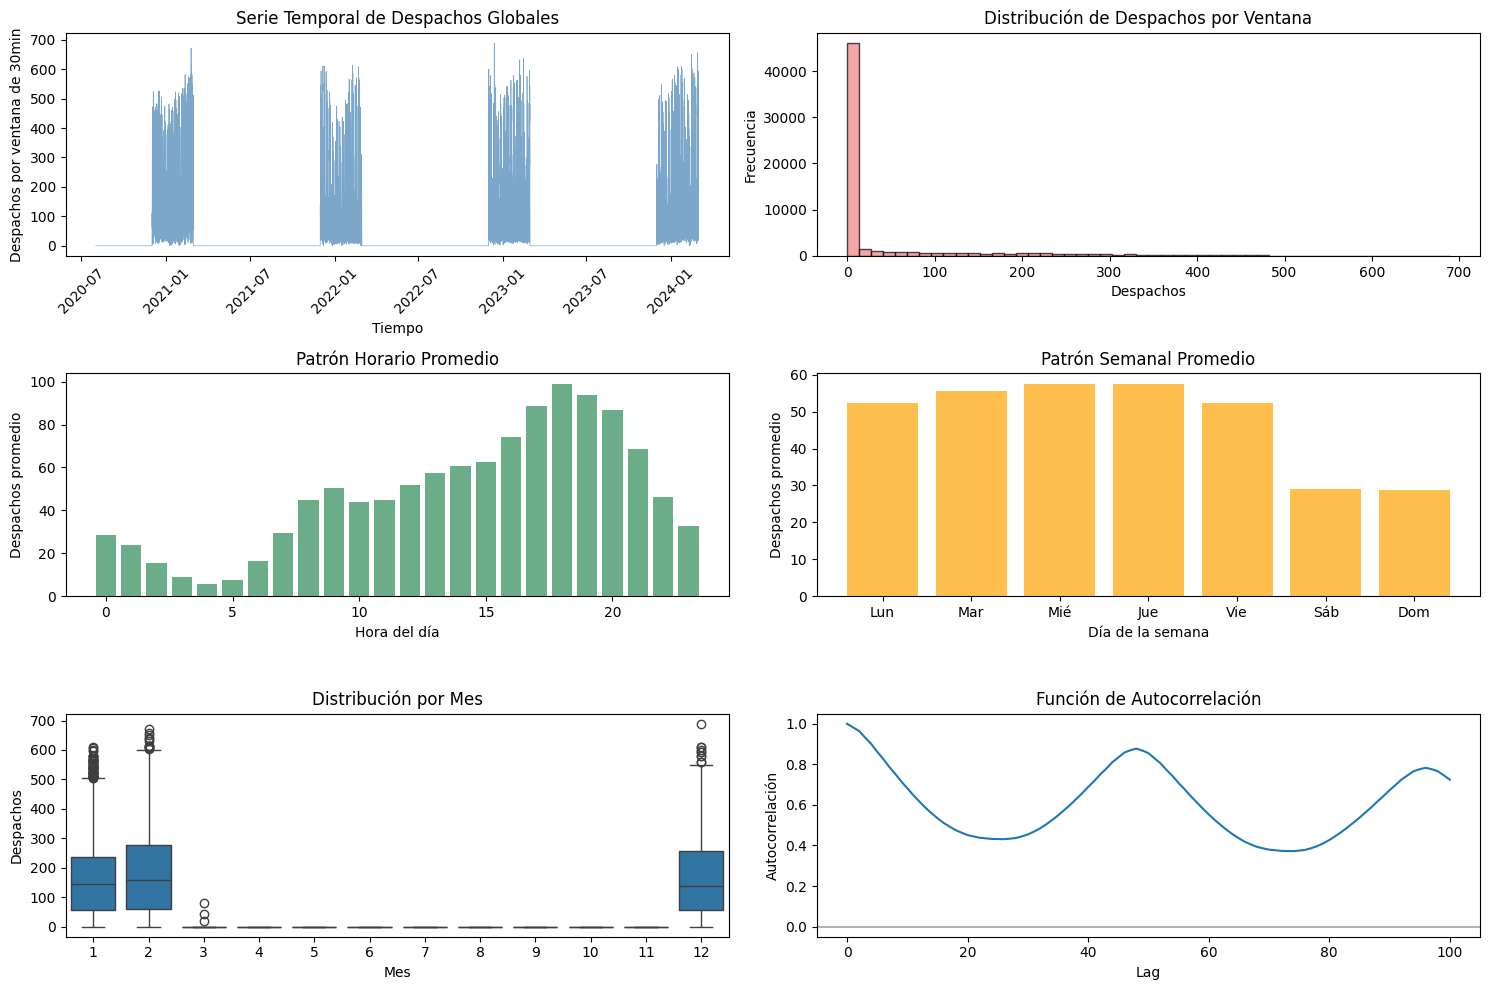


🔍 ANÁLISIS DE VARIABILIDAD:
Varianza: 10719.66
Desviación estándar: 103.54
Coeficiente de variación: 2.176


In [ ]:
### Análisis Global de Despachos: Proceso de Poisson
df_ts = df_ts[df_ts['timestamp'] > '2020-08-01']
# Agregar un conteo global de despachos por ventana de tiempo
print("📊 ANÁLISIS GLOBAL DE DESPACHOS")
print("="*50)

# Agregamos todos los despachos por timestamp para obtener la demanda global
despachos_globales = df_ts.groupby('timestamp')['despachos_count'].sum().reset_index()
despachos_globales = despachos_globales.sort_values('timestamp')

print(f"Total de ventanas temporales: {len(despachos_globales)}")
print(f"Despachos promedio por ventana: {despachos_globales['despachos_count'].mean():.2f}")
print(f"Despachos máximos en una ventana: {despachos_globales['despachos_count'].max()}")
print(f"Despachos mínimos en una ventana: {despachos_globales['despachos_count'].min()}")

# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas:")
print(despachos_globales['despachos_count'].describe())

# Visualización
plt.figure(figsize=(15, 10))

# Subplot 1: Serie temporal completa
plt.subplot(3, 2, 1)
plt.plot(despachos_globales['timestamp'], despachos_globales['despachos_count'], 
         linewidth=0.5, alpha=0.7, color='steelblue')
plt.title('Serie Temporal de Despachos Globales')
plt.xlabel('Tiempo')
plt.ylabel('Despachos por ventana de 30min')
plt.xticks(rotation=45)

# Subplot 2: Histograma
plt.subplot(3, 2, 2)
plt.hist(despachos_globales['despachos_count'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribución de Despachos por Ventana')
plt.xlabel('Despachos')
plt.ylabel('Frecuencia')

# Subplot 3: Patrones por hora
despachos_globales['hora'] = despachos_globales['timestamp'].dt.hour
hourly_pattern = despachos_globales.groupby('hora')['despachos_count'].mean()

plt.subplot(3, 2, 3)
plt.bar(hourly_pattern.index, hourly_pattern.values, alpha=0.7, color='seagreen')
plt.title('Patrón Horario Promedio')
plt.xlabel('Hora del día')
plt.ylabel('Despachos promedio')

# Subplot 4: Patrones por día de la semana
despachos_globales['dia_semana'] = despachos_globales['timestamp'].dt.dayofweek
daily_pattern = despachos_globales.groupby('dia_semana')['despachos_count'].mean()
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

plt.subplot(3, 2, 4)
plt.bar(range(7), daily_pattern.values, alpha=0.7, color='orange')
plt.title('Patrón Semanal Promedio')
plt.xlabel('Día de la semana')
plt.ylabel('Despachos promedio')
plt.xticks(range(7), dias)

# Subplot 5: Box plot por mes
despachos_globales['mes'] = despachos_globales['timestamp'].dt.month
plt.subplot(3, 2, 5)
sns.boxplot(data=despachos_globales, x='mes', y='despachos_count')
plt.title('Distribución por Mes')
plt.xlabel('Mes')   
plt.ylabel('Despachos')

# Subplot 6: Autocorrelación (primeros 100 lags)
from statsmodels.tsa.stattools import acf
plt.subplot(3, 2, 6)
autocorr = acf(despachos_globales['despachos_count'], nlags=100)
plt.plot(autocorr)
plt.title('Función de Autocorrelación')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n🔍 ANÁLISIS DE VARIABILIDAD:")
print(f"Varianza: {despachos_globales['despachos_count'].var():.2f}")
print(f"Desviación estándar: {despachos_globales['despachos_count'].std():.2f}")
print(f"Coeficiente de variación: {despachos_globales['despachos_count'].std()/despachos_globales['despachos_count'].mean():.3f}")


🎯 MODELADO DEL PROCESO DE POISSON GLOBAL
Ajustando modelo de Poisson global...
0.2407103107030966

📊 RESULTADOS DEL MODELO DE POISSON:
Lambda estimado (tasa promedio): 47.5798
Varianza teórica (debe ≈ lambda): 47.5798
Varianza observada: 10719.6584
Ratio varianza/media (debe ≈ 1 para Poisson): 225.2986

🧪 TESTS DE BONDAD DE AJUSTE:
Kolmogorov-Smirnov:
  Estadístico: 0.757018
  p-valor: 0.000000
  Ajuste: ❌ Pobre (α=0.05)


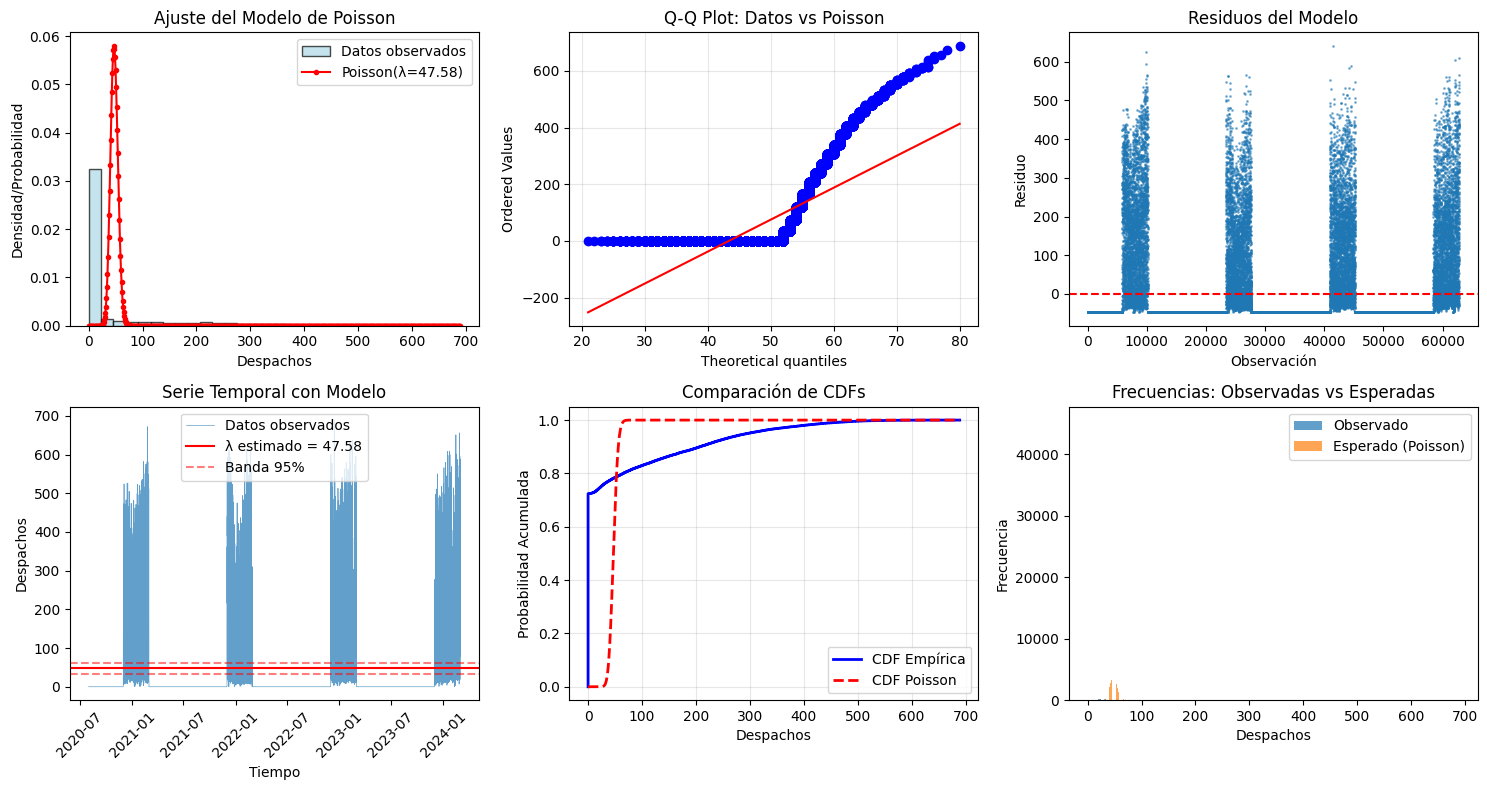


💡 INTERPRETACIÓN DEL MODELO:
• El sistema tiene una tasa promedio de 47.58 despachos cada 30 minutos
• En términos horarios: ~95.2 despachos por hora
• En términos diarios: ~2284 despachos por día (24h)
• ⚠️  Sobredispersión detectada (ratio = 225.299), considerar modelos alternativos

💾 Modelo Poisson global guardado en memoria para uso posterior


In [ ]:
print("🎯 MODELADO DEL PROCESO DE POISSON GLOBAL")
print("="*60)

def fit_poisson_model(data):
    """
    Ajusta un modelo de Poisson a los datos y calcula estadísticas.
    """
    # Estimar lambda (parámetro de la distribución de Poisson)
    lambda_est = data.mean()
    
    # Test de bondad de ajuste Kolmogorov-Smirnov
    from scipy.stats import kstest, poisson
    ks_stat, ks_pvalue = kstest(data, lambda x: poisson.cdf(x, lambda_est))
    
    # Chi-cuadrado test
    from scipy.stats import chisquare
    try:
        # Crear bins más robustos
        max_val = min(int(data.max()), int(lambda_est) + 20)  # Limitar rango para evitar bins vacíos
        bins = np.arange(max_val + 2)
        
        # Calcular frecuencias observadas
        observed_freq, _ = np.histogram(data, bins=bins)
        
        # Calcular frecuencias esperadas
        expected_freq = []
        for i in range(len(observed_freq)):
            prob = poisson.pmf(bins[i], lambda_est)
            expected_freq.append(prob * len(data))
        
        expected_freq = np.array(expected_freq)
        
        # Combinar bins con frecuencia esperada baja
        combined_observed = []
        combined_expected = []
        temp_obs = 0
        temp_exp = 0
        
        for i in range(len(observed_freq)):
            temp_obs += observed_freq[i]
            temp_exp += expected_freq[i]
            
            if temp_exp >= 5 or i == len(observed_freq) - 1:
                combined_observed.append(temp_obs)
                combined_expected.append(temp_exp)
                temp_obs = 0
                temp_exp = 0
        
        combined_observed = np.array(combined_observed)
        combined_expected = np.array(combined_expected)
        
        if len(combined_observed) >= 2:
            chi2_stat, chi2_pvalue = chisquare(combined_observed, combined_expected)
        else:
            chi2_stat, chi2_pvalue = np.nan, np.nan
            
    except Exception as e:
        print(f"Warning: Chi-cuadrado test falló: {e}")
        chi2_stat, chi2_pvalue = np.nan, np.nan
        # Usar valores originales para visualización
        bins = range(int(data.max()) + 2)
        observed_freq, _ = np.histogram(data, bins=bins)
        expected_freq = [poisson.pmf(i, lambda_est) * len(data) for i in range(len(observed_freq))]
    
    
    return {
        'lambda': lambda_est,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'chi2_statistic': chi2_stat,
        'chi2_pvalue': chi2_pvalue,
        'observed_freq': observed_freq,
        'expected_freq': expected_freq,
        'bins': bins
    }

# Ajustar modelo de Poisson global
print("Ajustando modelo de Poisson global...")
poisson_results = fit_poisson_model(despachos_globales['despachos_count'])

print(f"\n📊 RESULTADOS DEL MODELO DE POISSON:")
print(f"Lambda estimado (tasa promedio): {poisson_results['lambda']:.4f}")
print(f"Varianza teórica (debe ≈ lambda): {poisson_results['lambda']:.4f}")
print(f"Varianza observada: {despachos_globales['despachos_count'].var():.4f}")
print(f"Ratio varianza/media (debe ≈ 1 para Poisson): {despachos_globales['despachos_count'].var()/despachos_globales['despachos_count'].mean():.4f}")

print(f"\n🧪 TESTS DE BONDAD DE AJUSTE:")
print(f"Kolmogorov-Smirnov:")
print(f"  Estadístico: {poisson_results['ks_statistic']:.6f}")
print(f"  p-valor: {poisson_results['ks_pvalue']:.6f}")
print(f"  Ajuste: {'✅ Bueno' if poisson_results['ks_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

if not np.isnan(poisson_results['chi2_pvalue']):
    print(f"Chi-cuadrado:")
    print(f"  Estadístico: {poisson_results['chi2_statistic']:.6f}")
    print(f"  p-valor: {poisson_results['chi2_pvalue']:.6f}")
    print(f"  Ajuste: {'✅ Bueno' if poisson_results['chi2_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

# Visualización del ajuste
plt.figure(figsize=(15, 8))

# Subplot 1: Histograma vs distribución teórica
plt.subplot(2, 3, 1)
plt.hist(despachos_globales['despachos_count'], bins=30, density=True, alpha=0.7, 
         color='lightblue', edgecolor='black', label='Datos observados')

# Superponer distribución de Poisson teórica
x_range = np.arange(0, despachos_globales['despachos_count'].max() + 1)
poisson_pmf = stats.poisson.pmf(x_range, poisson_results['lambda'])
plt.plot(x_range, poisson_pmf, 'ro-', markersize=3, label=f'Poisson(λ={poisson_results["lambda"]:.2f})')
plt.title('Ajuste del Modelo de Poisson')
plt.xlabel('Despachos')
plt.ylabel('Densidad/Probabilidad')
plt.legend()

# Subplot 2: Q-Q plot
plt.subplot(2, 3, 2)
from scipy.stats import probplot
probplot(despachos_globales['despachos_count'], dist=stats.poisson, 
         sparams=(poisson_results['lambda'],), plot=plt)
plt.title('Q-Q Plot: Datos vs Poisson')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuos
plt.subplot(2, 3, 3)
expected_values = np.full(len(despachos_globales), poisson_results['lambda'])
residuals = despachos_globales['despachos_count'] - expected_values
plt.scatter(range(len(residuals)), residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos del Modelo')
plt.xlabel('Observación')
plt.ylabel('Residuo')

# Subplot 4: Serie temporal con banda de confianza
plt.subplot(2, 3, 4)
lambda_est = poisson_results['lambda']
upper_bound = lambda_est + 2*np.sqrt(lambda_est)  # ~95% confianza
lower_bound = max(0, lambda_est - 2*np.sqrt(lambda_est))

plt.plot(despachos_globales['timestamp'], despachos_globales['despachos_count'], 
         linewidth=0.5, alpha=0.7, label='Datos observados')
plt.axhline(y=lambda_est, color='red', linestyle='-', label=f'λ estimado = {lambda_est:.2f}')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5, label='Banda 95%')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Serie Temporal con Modelo')
plt.xlabel('Tiempo')
plt.ylabel('Despachos')
plt.legend()
plt.xticks(rotation=45)

# Subplot 5: Comparación acumulativa
plt.subplot(2, 3, 5)
sorted_data = np.sort(despachos_globales['despachos_count'])
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
theoretical_cdf = stats.poisson.cdf(sorted_data, poisson_results['lambda'])

plt.plot(sorted_data, empirical_cdf, 'b-', label='CDF Empírica', linewidth=2)
plt.plot(sorted_data, theoretical_cdf, 'r--', label='CDF Poisson', linewidth=2)
plt.title('Comparación de CDFs')
plt.xlabel('Despachos')
plt.ylabel('Probabilidad Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Frecuencias observadas vs esperadas
plt.subplot(2, 3, 6)
# Convertir bins a array numpy para poder hacer operaciones
bins_array = np.array(list(poisson_results['bins'][:-1])) if isinstance(poisson_results['bins'], range) else poisson_results['bins'][:-1]
x_vals = bins_array
plt.bar(x_vals, poisson_results['observed_freq'], alpha=0.7, label='Observado', width=0.4)
plt.bar(x_vals + 0.4, poisson_results['expected_freq'], alpha=0.7, label='Esperado (Poisson)', width=0.4)
plt.title('Frecuencias: Observadas vs Esperadas')
plt.xlabel('Despachos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

# Interpretación del modelo
print(f"\n💡 INTERPRETACIÓN DEL MODELO:")
print(f"• El sistema tiene una tasa promedio de {poisson_results['lambda']:.2f} despachos cada 30 minutos")
print(f"• En términos horarios: ~{poisson_results['lambda']*2:.1f} despachos por hora")
print(f"• En términos diarios: ~{poisson_results['lambda']*48:.0f} despachos por día (24h)")

ratio_var_mean = despachos_globales['despachos_count'].var()/despachos_globales['despachos_count'].mean()
if abs(ratio_var_mean - 1) < 0.1:
    print(f"• ✅ El ratio varianza/media ≈ 1, sugiere que el proceso Poisson es apropiado")
elif ratio_var_mean > 1.1:
    print(f"• ⚠️  Sobredispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")
else:
    print(f"• ⚠️  Subdispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")

# Guardar resultados del modelo
model_results = {
    'model_type': 'poisson_global',
    'lambda_estimated': poisson_results['lambda'],
    'timestamp_range': (despachos_globales['timestamp'].min(), despachos_globales['timestamp'].max()),
    'n_observations': len(despachos_globales),
    'goodness_of_fit': {
        'ks_statistic': poisson_results['ks_statistic'],
        'ks_pvalue': poisson_results['ks_pvalue'],
        'chi2_statistic': poisson_results['chi2_statistic'],
        'chi2_pvalue': poisson_results['chi2_pvalue']
    },
    'variance_ratio': ratio_var_mean
}

print(f"\n💾 Modelo Poisson global guardado en memoria para uso posterior")


📊 ANÁLISIS GLOBAL DE ARRIBOS
Total de ventanas temporales: 62783
Arribos promedio por ventana: 47.58
Arribos máximos en una ventana: 697
Arribos mínimos en una ventana: 0

📈 Estadísticas descriptivas:
count    62783.000000
mean        47.580603
std        103.096592
min          0.000000
25%          0.000000
50%          0.000000
75%         25.000000
max        697.000000
Name: arribos_count, dtype: float64


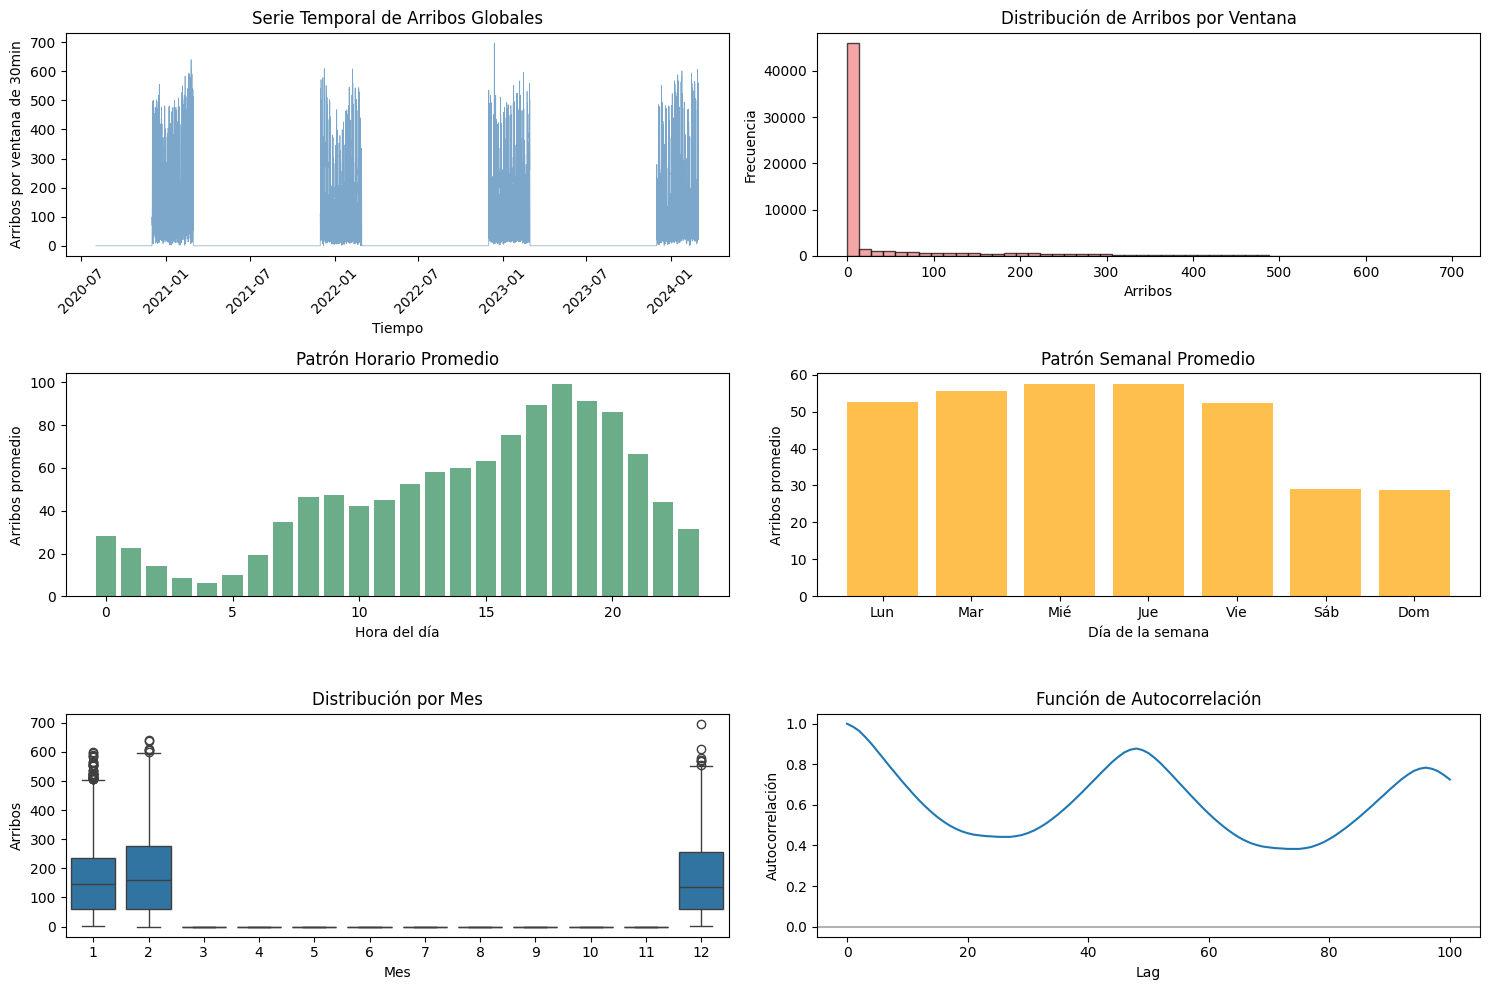


🔍 ANÁLISIS DE VARIABILIDAD:
Varianza: 10628.91
Desviación estándar: 103.10
Coeficiente de variación: 2.167


In [ ]:
### Análisis Global de Arribos: Proceso de Poisson
# Agregar un conteo global de arribos por ventana de tiempo
print("📊 ANÁLISIS GLOBAL DE ARRIBOS")
print("="*50)

# Agregamos todos los arribos por timestamp para obtener la demanda global de llegadas
arribos_globales = df_ts.groupby('timestamp')['arribos_count'].sum().reset_index()
arribos_globales = arribos_globales.sort_values('timestamp')

print(f"Total de ventanas temporales: {len(arribos_globales)}")
print(f"Arribos promedio por ventana: {arribos_globales['arribos_count'].mean():.2f}")
print(f"Arribos máximos en una ventana: {arribos_globales['arribos_count'].max()}")
print(f"Arribos mínimos en una ventana: {arribos_globales['arribos_count'].min()}")

# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas:")
print(arribos_globales['arribos_count'].describe())

# Visualización
plt.figure(figsize=(15, 10))

# Subplot 1: Serie temporal completa
plt.subplot(3, 2, 1)
plt.plot(arribos_globales['timestamp'], arribos_globales['arribos_count'], 
         linewidth=0.5, alpha=0.7, color='steelblue')
plt.title('Serie Temporal de Arribos Globales')
plt.xlabel('Tiempo')
plt.ylabel('Arribos por ventana de 30min')
plt.xticks(rotation=45)

# Subplot 2: Histograma
plt.subplot(3, 2, 2)
plt.hist(arribos_globales['arribos_count'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribución de Arribos por Ventana')
plt.xlabel('Arribos')
plt.ylabel('Frecuencia')

# Subplot 3: Patrones por hora
arribos_globales['hora'] = arribos_globales['timestamp'].dt.hour
hourly_pattern = arribos_globales.groupby('hora')['arribos_count'].mean()

plt.subplot(3, 2, 3)
plt.bar(hourly_pattern.index, hourly_pattern.values, alpha=0.7, color='seagreen')
plt.title('Patrón Horario Promedio')
plt.xlabel('Hora del día')
plt.ylabel('Arribos promedio')

# Subplot 4: Patrones por día de la semana
arribos_globales['dia_semana'] = arribos_globales['timestamp'].dt.dayofweek
daily_pattern = arribos_globales.groupby('dia_semana')['arribos_count'].mean()
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

plt.subplot(3, 2, 4)
plt.bar(range(7), daily_pattern.values, alpha=0.7, color='orange')
plt.title('Patrón Semanal Promedio')
plt.xlabel('Día de la semana')
plt.ylabel('Arribos promedio')
plt.xticks(range(7), dias)

# Subplot 5: Box plot por mes
arribos_globales['mes'] = arribos_globales['timestamp'].dt.month
plt.subplot(3, 2, 5)
sns.boxplot(data=arribos_globales, x='mes', y='arribos_count')
plt.title('Distribución por Mes')
plt.xlabel('Mes')
plt.ylabel('Arribos')

# Subplot 6: Autocorrelación (primeros 100 lags)
from statsmodels.tsa.stattools import acf
plt.subplot(3, 2, 6)
autocorr = acf(arribos_globales['arribos_count'], nlags=100)
plt.plot(autocorr)
plt.title('Función de Autocorrelación')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n🔍 ANÁLISIS DE VARIABILIDAD:")
print(f"Varianza: {arribos_globales['arribos_count'].var():.2f}")
print(f"Desviación estándar: {arribos_globales['arribos_count'].std():.2f}")
print(f"Coeficiente de variación: {arribos_globales['arribos_count'].std()/arribos_globales['arribos_count'].mean():.3f}")


🎯 MODELADO DEL PROCESO DE POISSON GLOBAL - ARRIBOS
Ajustando modelo de Poisson global para arribos...
0.24253150282622807

📊 RESULTADOS DEL MODELO DE POISSON PARA ARRIBOS:
Lambda estimado (tasa promedio): 47.5806
Varianza teórica (debe ≈ lambda): 47.5806
Varianza observada: 10628.9072
Ratio varianza/media (debe ≈ 1 para Poisson): 223.3874

🧪 TESTS DE BONDAD DE AJUSTE:
Kolmogorov-Smirnov:
  Estadístico: 0.755538
  p-valor: 0.000000
  Ajuste: ❌ Pobre (α=0.05)


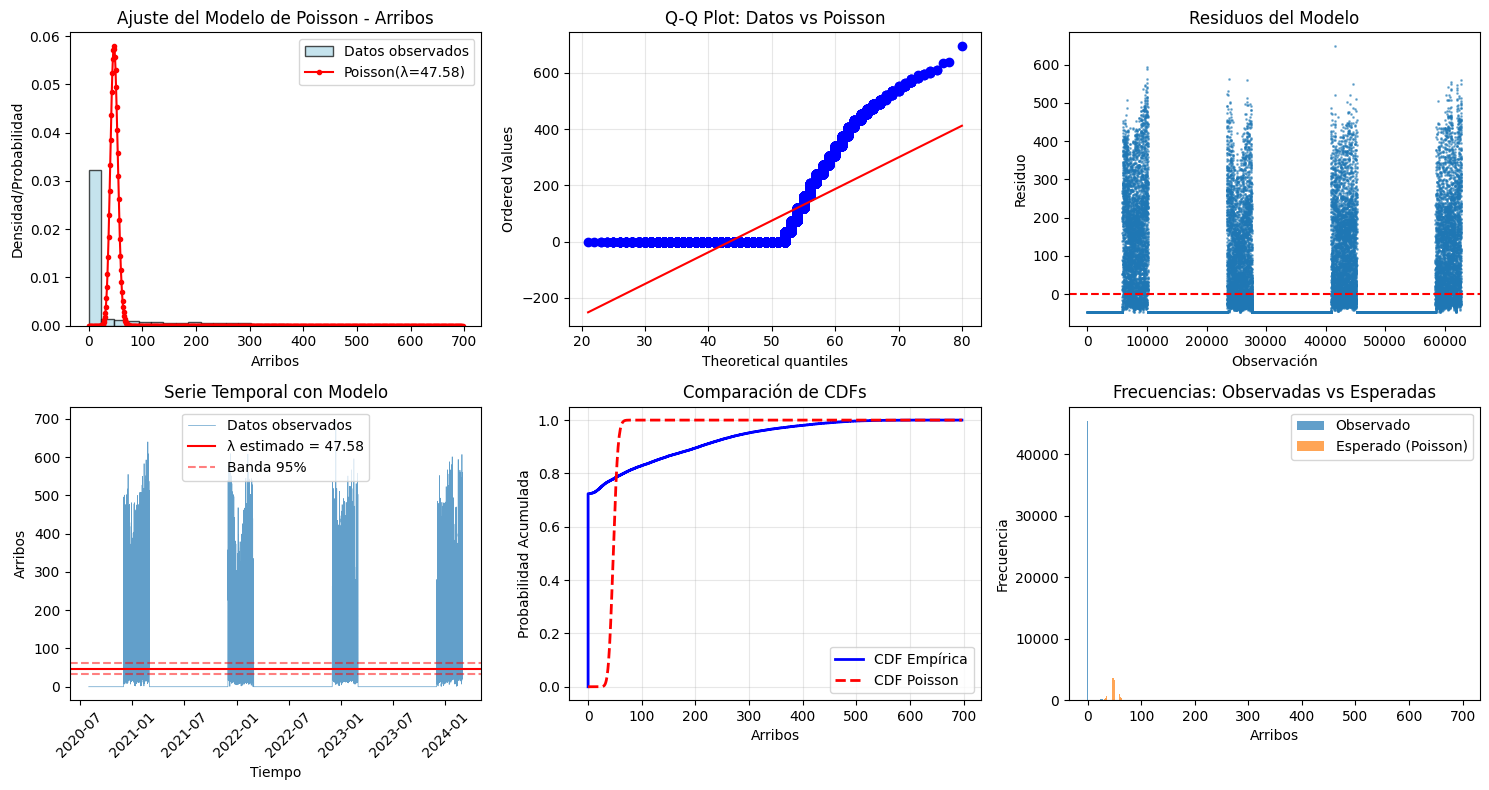


💡 INTERPRETACIÓN DEL MODELO DE ARRIBOS:
• El sistema tiene una tasa promedio de 47.58 arribos cada 30 minutos
• En términos horarios: ~95.2 arribos por hora
• En términos diarios: ~2284 arribos por día (24h)
• ⚠️  Sobredispersión detectada (ratio = 223.387), considerar modelos alternativos

💾 Modelo Poisson global de arribos guardado en memoria para uso posterior


In [ ]:
print("🎯 MODELADO DEL PROCESO DE POISSON GLOBAL - ARRIBOS")
print("="*60)

def fit_poisson_model(data):
    """
    Ajusta un modelo de Poisson a los datos y calcula estadísticas.
    """
    # Estimar lambda (parámetro de la distribución de Poisson)
    lambda_est = data.mean()
    
    # Test de bondad de ajuste Kolmogorov-Smirnov
    from scipy.stats import kstest, poisson
    ks_stat, ks_pvalue = kstest(data, lambda x: poisson.cdf(x, lambda_est))
    
    # Chi-cuadrado test
    from scipy.stats import chisquare
    try:
        # Crear bins más robustos
        max_val = min(int(data.max()), int(lambda_est) + 20)  # Limitar rango para evitar bins vacíos
        bins = np.arange(max_val + 2)
        
        # Calcular frecuencias observadas
        observed_freq, _ = np.histogram(data, bins=bins)
        
        # Calcular frecuencias esperadas
        expected_freq = []
        for i in range(len(observed_freq)):
            prob = poisson.pmf(bins[i], lambda_est)
            expected_freq.append(prob * len(data))
        
        expected_freq = np.array(expected_freq)
        
        # Combinar bins con frecuencia esperada baja
        combined_observed = []
        combined_expected = []
        temp_obs = 0
        temp_exp = 0
        
        for i in range(len(observed_freq)):
            temp_obs += observed_freq[i]
            temp_exp += expected_freq[i]
            
            if temp_exp >= 5 or i == len(observed_freq) - 1:
                combined_observed.append(temp_obs)
                combined_expected.append(temp_exp)
                temp_obs = 0
                temp_exp = 0
        
        combined_observed = np.array(combined_observed)
        combined_expected = np.array(combined_expected)
        
        if len(combined_observed) >= 2:
            chi2_stat, chi2_pvalue = chisquare(combined_observed, combined_expected)
        else:
            chi2_stat, chi2_pvalue = np.nan, np.nan
            
    except Exception as e:
        print(f"Warning: Chi-cuadrado test falló: {e}")
        chi2_stat, chi2_pvalue = np.nan, np.nan
        # Usar valores originales para visualización
        bins = range(int(data.max()) + 2)
        observed_freq, _ = np.histogram(data, bins=bins)
        expected_freq = [poisson.pmf(i, lambda_est) * len(data) for i in range(len(observed_freq))]
    
    
    return {
        'lambda': lambda_est,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'chi2_statistic': chi2_stat,
        'chi2_pvalue': chi2_pvalue,
        'observed_freq': observed_freq,
        'expected_freq': expected_freq,
        'bins': bins
    }

# Ajustar modelo de Poisson global para ARRIBOS
print("Ajustando modelo de Poisson global para arribos...")
poisson_results = fit_poisson_model(arribos_globales['arribos_count'])

print(f"\n📊 RESULTADOS DEL MODELO DE POISSON PARA ARRIBOS:")
print(f"Lambda estimado (tasa promedio): {poisson_results['lambda']:.4f}")
print(f"Varianza teórica (debe ≈ lambda): {poisson_results['lambda']:.4f}")
print(f"Varianza observada: {arribos_globales['arribos_count'].var():.4f}")
print(f"Ratio varianza/media (debe ≈ 1 para Poisson): {arribos_globales['arribos_count'].var()/arribos_globales['arribos_count'].mean():.4f}")

print(f"\n🧪 TESTS DE BONDAD DE AJUSTE:")
print(f"Kolmogorov-Smirnov:")
print(f"  Estadístico: {poisson_results['ks_statistic']:.6f}")
print(f"  p-valor: {poisson_results['ks_pvalue']:.6f}")
print(f"  Ajuste: {'✅ Bueno' if poisson_results['ks_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

if not np.isnan(poisson_results['chi2_pvalue']):
    print(f"Chi-cuadrado:")
    print(f"  Estadístico: {poisson_results['chi2_statistic']:.6f}")
    print(f"  p-valor: {poisson_results['chi2_pvalue']:.6f}")
    print(f"  Ajuste: {'✅ Bueno' if poisson_results['chi2_pvalue'] > 0.05 else '❌ Pobre'} (α=0.05)")

# Visualización del ajuste
plt.figure(figsize=(15, 8))

# Subplot 1: Histograma vs distribución teórica
plt.subplot(2, 3, 1)
plt.hist(arribos_globales['arribos_count'], bins=30, density=True, alpha=0.7, 
         color='lightblue', edgecolor='black', label='Datos observados')

# Superponer distribución de Poisson teórica
x_range = np.arange(0, arribos_globales['arribos_count'].max() + 1)
poisson_pmf = stats.poisson.pmf(x_range, poisson_results['lambda'])
plt.plot(x_range, poisson_pmf, 'ro-', markersize=3, label=f'Poisson(λ={poisson_results["lambda"]:.2f})')
plt.title('Ajuste del Modelo de Poisson - Arribos')
plt.xlabel('Arribos')
plt.ylabel('Densidad/Probabilidad')
plt.legend()

# Subplot 2: Q-Q plot
plt.subplot(2, 3, 2)
from scipy.stats import probplot
probplot(arribos_globales['arribos_count'], dist=stats.poisson, 
         sparams=(poisson_results['lambda'],), plot=plt)
plt.title('Q-Q Plot: Datos vs Poisson')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuos
plt.subplot(2, 3, 3)
expected_values = np.full(len(arribos_globales), poisson_results['lambda'])
residuals = arribos_globales['arribos_count'] - expected_values
plt.scatter(range(len(residuals)), residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuos del Modelo')
plt.xlabel('Observación')
plt.ylabel('Residuo')

# Subplot 4: Serie temporal con banda de confianza
plt.subplot(2, 3, 4)
lambda_est = poisson_results['lambda']
upper_bound = lambda_est + 2*np.sqrt(lambda_est)  # ~95% confianza
lower_bound = max(0, lambda_est - 2*np.sqrt(lambda_est))

plt.plot(arribos_globales['timestamp'], arribos_globales['arribos_count'], 
         linewidth=0.5, alpha=0.7, label='Datos observados')
plt.axhline(y=lambda_est, color='red', linestyle='-', label=f'λ estimado = {lambda_est:.2f}')
plt.axhline(y=upper_bound, color='red', linestyle='--', alpha=0.5, label='Banda 95%')
plt.axhline(y=lower_bound, color='red', linestyle='--', alpha=0.5)
plt.title('Serie Temporal con Modelo')
plt.xlabel('Tiempo')
plt.ylabel('Arribos')
plt.legend()
plt.xticks(rotation=45)

# Subplot 5: Comparación acumulativa
plt.subplot(2, 3, 5)
sorted_data = np.sort(arribos_globales['arribos_count'])
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
theoretical_cdf = stats.poisson.cdf(sorted_data, poisson_results['lambda'])

plt.plot(sorted_data, empirical_cdf, 'b-', label='CDF Empírica', linewidth=2)
plt.plot(sorted_data, theoretical_cdf, 'r--', label='CDF Poisson', linewidth=2)
plt.title('Comparación de CDFs')
plt.xlabel('Arribos')
plt.ylabel('Probabilidad Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Frecuencias observadas vs esperadas
plt.subplot(2, 3, 6)
# Convertir bins a array numpy para poder hacer operaciones
bins_array = np.array(list(poisson_results['bins'][:-1])) if isinstance(poisson_results['bins'], range) else poisson_results['bins'][:-1]
x_vals = bins_array
plt.bar(x_vals, poisson_results['observed_freq'], alpha=0.7, label='Observado', width=0.4)
plt.bar(x_vals + 0.4, poisson_results['expected_freq'], alpha=0.7, label='Esperado (Poisson)', width=0.4)
plt.title('Frecuencias: Observadas vs Esperadas')
plt.xlabel('Arribos')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

# Interpretación del modelo
print(f"\n💡 INTERPRETACIÓN DEL MODELO DE ARRIBOS:")
print(f"• El sistema tiene una tasa promedio de {poisson_results['lambda']:.2f} arribos cada 30 minutos")
print(f"• En términos horarios: ~{poisson_results['lambda']*2:.1f} arribos por hora")
print(f"• En términos diarios: ~{poisson_results['lambda']*48:.0f} arribos por día (24h)")

ratio_var_mean = arribos_globales['arribos_count'].var()/arribos_globales['arribos_count'].mean()
if abs(ratio_var_mean - 1) < 0.1:
    print(f"• ✅ El ratio varianza/media ≈ 1, sugiere que el proceso Poisson es apropiado")
elif ratio_var_mean > 1.1:
    print(f"• ⚠️  Sobredispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")
else:
    print(f"• ⚠️  Subdispersión detectada (ratio = {ratio_var_mean:.3f}), considerar modelos alternativos")

# Guardar resultados del modelo
model_results = {
    'model_type': 'poisson_global_arribos',
    'lambda_estimated': poisson_results['lambda'],
    'timestamp_range': (arribos_globales['timestamp'].min(), arribos_globales['timestamp'].max()),
    'n_observations': len(arribos_globales),
    'goodness_of_fit': {
        'ks_statistic': poisson_results['ks_statistic'],
        'ks_pvalue': poisson_results['ks_pvalue'],
        'chi2_statistic': poisson_results['chi2_statistic'],
        'chi2_pvalue': poisson_results['chi2_pvalue']
    },
    'variance_ratio': ratio_var_mean
}

print(f"\n💾 Modelo Poisson global de arribos guardado en memoria para uso posterior")


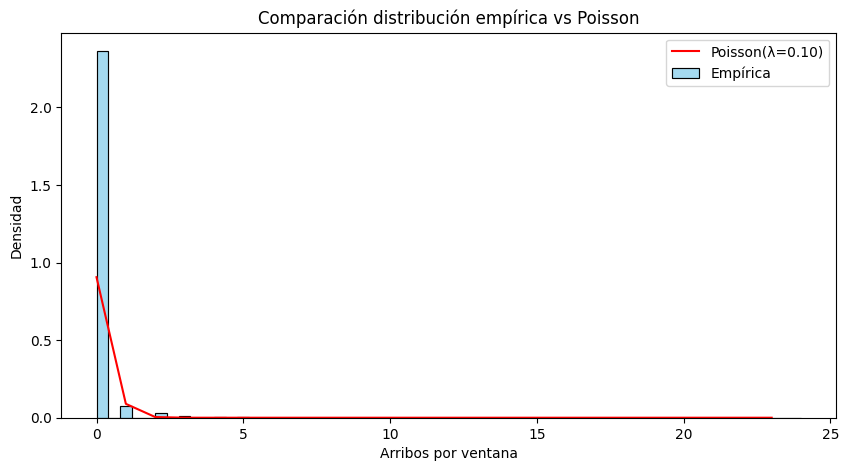

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# Datos: arribos por ventana
arribos = df_ts['arribos_count']

# Parámetro lambda estimado
lambda_hat = arribos.mean()

# Distribución empírica
plt.figure(figsize=(10,5))
sns.histplot(arribos, bins=60, stat='density', color='skyblue', label='Empírica', kde=False)

# Distribución teórica de Poisson
x = np.arange(0, arribos.max())
poisson_pmf = poisson.pmf(x, mu=lambda_hat)
plt.plot(x, poisson_pmf, 'r-', label=f'Poisson(λ={lambda_hat:.2f})')

plt.title("Comparación distribución empírica vs Poisson")
plt.xlabel("Arribos por ventana")
plt.ylabel("Densidad")
plt.legend()
plt.show()


Test de bondad de ajuste
chi cuadrado

In [ ]:
from scipy.stats import chisquare

# Histograma empírico
hist_vals, bin_edges = np.histogram(arribos, bins=np.arange(0, arribos.max()+2))
expected = poisson.pmf(np.arange(len(hist_vals)), mu=lambda_hat) * len(arribos)

chi2_stat, p_value = chisquare(hist_vals, f_exp=expected)
print(f"Chi2 = {chi2_stat:.2f}, p = {p_value:.4f}")


Chi2 = 123609756866812056722295110946481258889216.00, p = 0.0000


hora
0     0.058197
1     0.047058
2     0.029113
3     0.017305
4     0.012487
5     0.021155
6     0.039882
7     0.071822
8     0.096121
9     0.098076
10    0.087138
11    0.093747
12    0.108790
13    0.120688
14    0.124765
15    0.131263
16    0.156825
17    0.185773
18    0.206041
19    0.189770
20    0.178305
21    0.138051
22    0.091079
23    0.065694
Name: arribos_count, dtype: float64


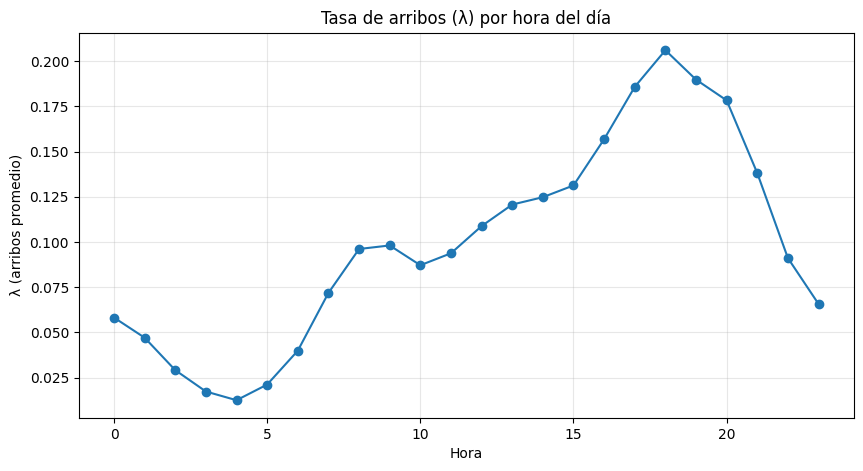

In [ ]:
import pandas as pd

# Suponiendo que ya tenés un dataframe llamado df con 'timestamp' y 'arribos_count'
df_ts['hora'] = pd.to_datetime(df_ts['timestamp']).dt.hour

# Estimar lambda por hora
lambdas_por_hora = df_ts.groupby('hora')['arribos_count'].mean()
print(lambdas_por_hora)

# Graficar lambda por hora
plt.figure(figsize=(10,5))
plt.plot(lambdas_por_hora.index, lambdas_por_hora.values, marker='o')
plt.title('Tasa de arribos (λ) por hora del día')
plt.xlabel('Hora')
plt.ylabel('λ (arribos promedio)')
plt.grid(True, alpha=0.3)
plt.show()



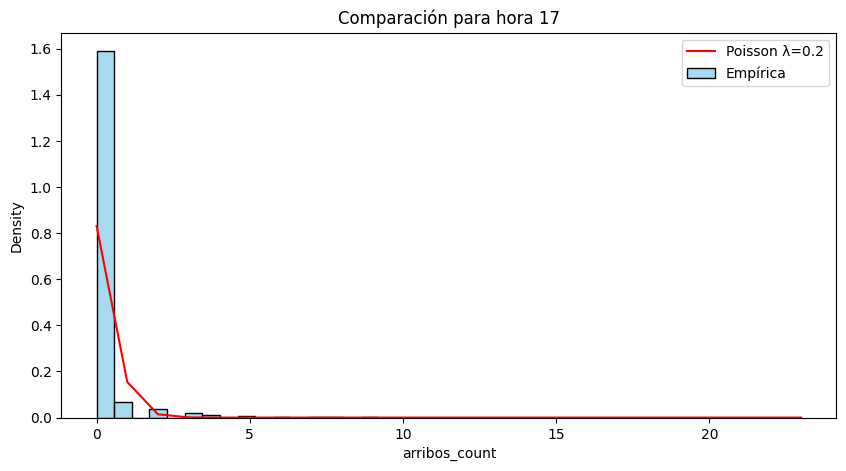

In [ ]:
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

hora_a_ver = 17
subset = df_ts[df_ts['hora'] == hora_a_ver]['arribos_count']
lambda_h = lambdas_por_hora[hora_a_ver]

plt.figure(figsize=(10,5))
sns.histplot(subset, bins=40, stat='density', color='skyblue', label='Empírica')
x = np.arange(0, subset.max() + 1)
plt.plot(x, poisson.pmf(x, lambda_h), 'r-', label=f'Poisson λ={lambda_h:.1f}')
plt.title(f'Comparación para hora {hora_a_ver}')
plt.legend()
plt.show()


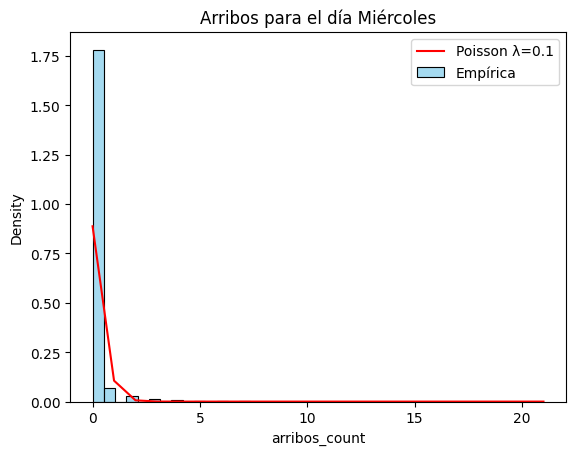

In [ ]:
df = df_ts
df['dia_semana'] = pd.to_datetime(df['timestamp']).dt.dayofweek  # 0=Lunes, 6=Domingo
lambdas_por_dia = df.groupby('dia_semana')['arribos_count'].mean()

dia = 2  # Miércoles
subset = df[df['dia_semana'] == dia]['arribos_count']
lambda_d = lambdas_por_dia[dia]

sns.histplot(subset, bins=40, stat='density', label='Empírica', color='skyblue')
x = np.arange(0, subset.max()+1)
plt.plot(x, poisson.pmf(x, lambda_d), 'r-', label=f'Poisson λ={lambda_d:.1f}')
plt.title('Arribos para el día Miércoles')
plt.legend()
plt.show()


In [ ]:
df['mes'] = pd.to_datetime(df['timestamp']).dt.month
lambdas_por_mes = df.groupby('mes')['arribos_count'].mean()

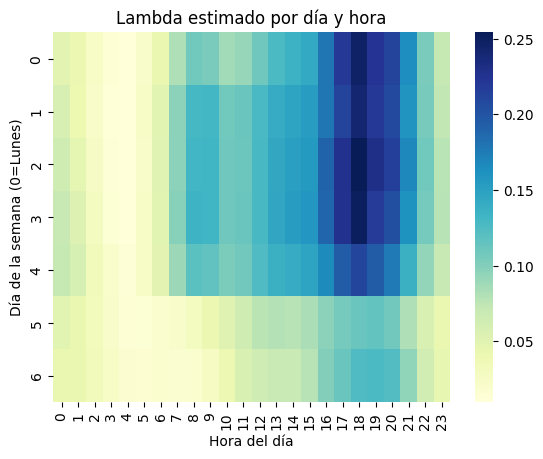

In [ ]:
grouped = df.groupby(['dia_semana', 'hora'])['arribos_count'].mean().unstack()
sns.heatmap(grouped, cmap="YlGnBu")
plt.title("Lambda estimado por día y hora")
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana (0=Lunes)")
plt.show()


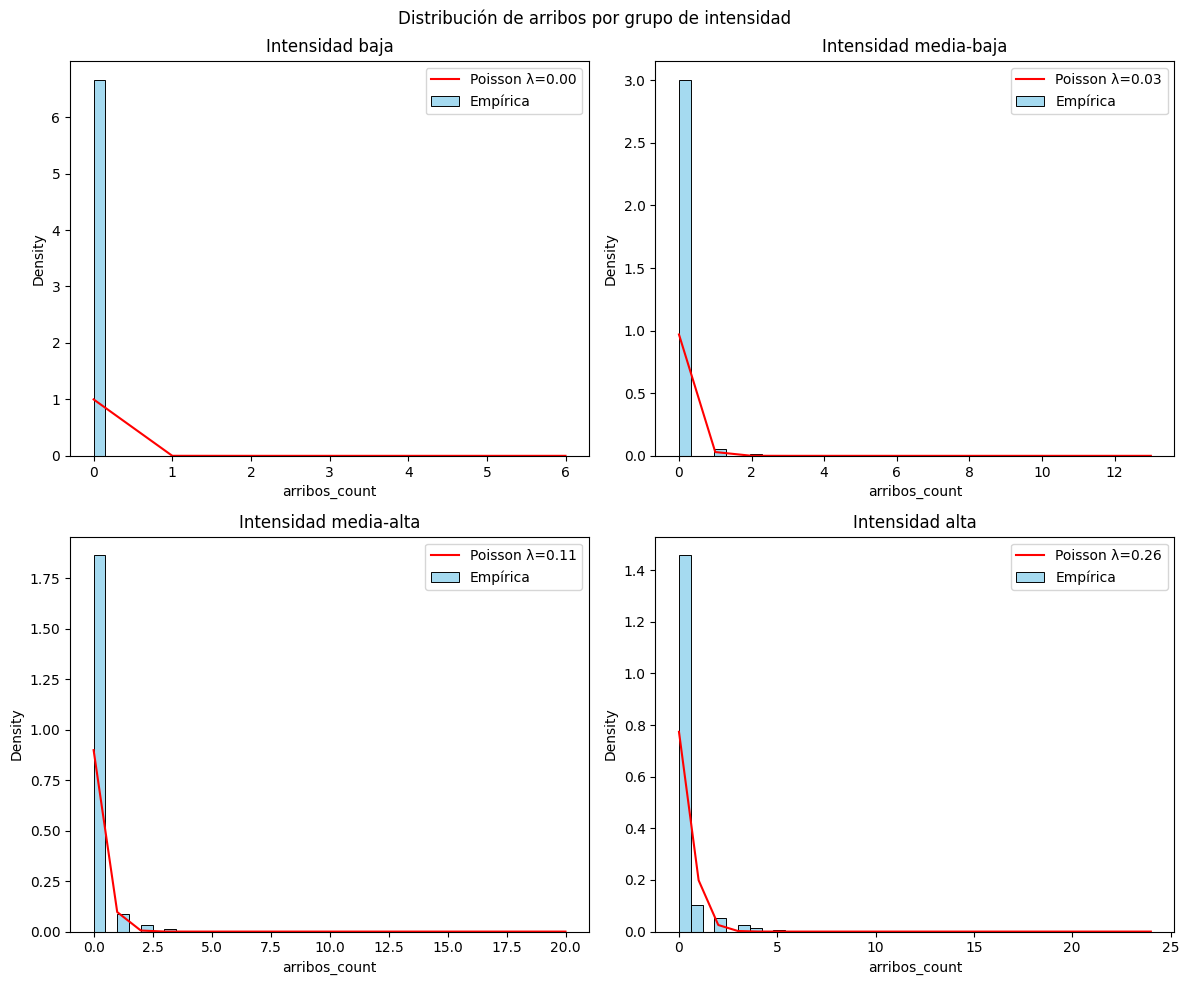

In [ ]:
# Total de arribos por estación
uso_por_estacion = df.groupby('id_estacion')['arribos_count'].sum()
df['grupo_intensidad'] = df['id_estacion'].map(uso_por_estacion)
df['grupo_intensidad'] = pd.qcut(df['grupo_intensidad'], q=4, labels=['baja', 'media-baja', 'media-alta', 'alta'])

# Crear subplots para cada grupo de intensidad
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribución de arribos por grupo de intensidad')

for (grupo, subset), ax in zip(df.groupby('grupo_intensidad'), axes.flat):
    lambda_g = subset['arribos_count'].mean()
    
    sns.histplot(data=subset, x='arribos_count', bins=40, stat='density', 
                 label='Empírica', color='skyblue', ax=ax)
    
    x = np.arange(0, subset['arribos_count'].max()+1)
    ax.plot(x, poisson.pmf(x, lambda_g), 'r-', 
            label=f'Poisson λ={lambda_g:.2f}')
    
    ax.set_title(f'Intensidad {grupo}')
    ax.legend()

plt.tight_layout()
plt.show()


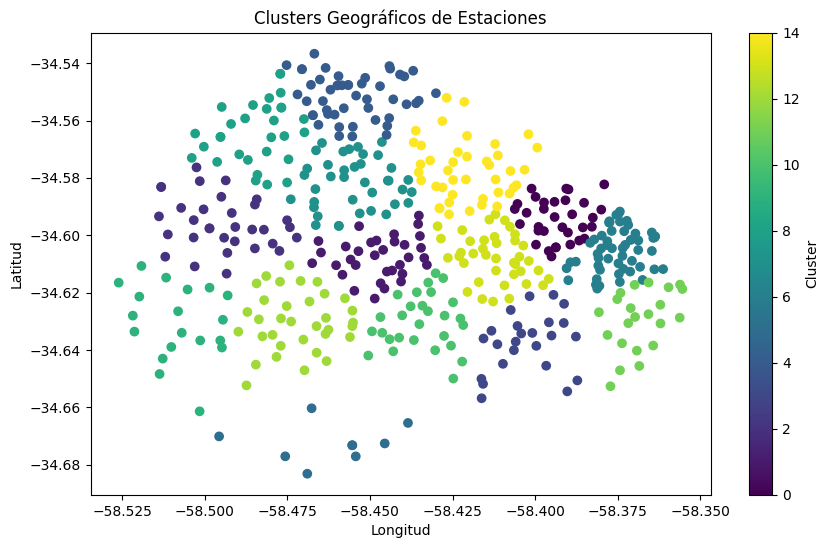

In [ ]:
from sklearn.cluster import KMeans

coords = df[['id_estacion', 'lat_estacion', 'long_estacion']].drop_duplicates()
kmeans = KMeans(n_clusters=15, random_state=42).fit(coords[['lat_estacion', 'long_estacion']])
coords['cluster_geo'] = kmeans.labels_
if 'cluster_geo' in df.columns:
    df = df.drop(columns=['cluster_geo'])

df = df.merge(coords[['id_estacion', 'cluster_geo']], on='id_estacion', how='left')

# Visualizar clusters geográficos
plt.figure(figsize=(10, 6))
plt.scatter(coords['long_estacion'], coords['lat_estacion'], 
           c=coords['cluster_geo'], cmap='viridis')
plt.title('Clusters Geográficos de Estaciones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Cluster')
plt.show()




In [ ]:
uso_por_estacion = df.groupby('id_estacion')['arribos_count'].sum()
df['grupo_intensidad'] = df['id_estacion'].map(uso_por_estacion)
df['grupo_intensidad'] = pd.qcut(df['grupo_intensidad'], q=4, labels=['baja', 'media-baja', 'media-alta', 'alta'])

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Asegurarse de que las variables categóricas estén tratadas como tales
df['hora'] = df['hora'].astype('category')
df['dia_semana'] = df['dia_semana'].astype('category')
df['mes'] = df['mes'].astype('category')
df['grupo_intensidad'] = df['grupo_intensidad'].astype('category')
df['cluster_geo'] = df['cluster_geo'].astype('category')

# Fórmula del modelo
formula = "arribos_count ~ C(hora) + C(dia_semana) + C(mes) + C(grupo_intensidad) + C(cluster_geo) + proporcion_mujeres + edad_usuario_mean + despachos_count"

# Ajustar GLM Poisson
modelo = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

# Resumen del modelo
print(modelo.summary())

df


MemoryError: 

In [ ]:
df['lambda_pred'] = modelo.predict(df)
import seaborn as sns
sns.scatterplot(data=df, x='lambda_pred', y='arribos_count', alpha=0.3)
plt.plot([0, df['lambda_pred'].max()], [0, df['lambda_pred'].max()], 'r--')  # línea 45°
plt.xlabel("λ predicho")
plt.ylabel("Arribos reales")
plt.title("Predicción del modelo Poisson")
plt.show()


In [ ]:
import xgboost as xgb
cat_features = ['hora', 'dia_semana', 'mes', 'grupo_intensidad', 'cluster_geo','año','dia_mes','es_fin_semana']
num_features = ['proporcion_mujeres', 'edad_usuario_std','edad_usuario_mean', 'despachos_count','arribos_prev_count','duracion_recorrido_count','duracion_recorrido_std','duracion_recorrido_mean','long_estacion','lat_estacion','id_estacion']

X = df[cat_features + num_features].copy()

# Convierte a dummies solo las categóricas (equivale a C(...) en fórmulas)
X_encoded = pd.get_dummies(X, columns=cat_features, drop_first=True)

y = df['arribos_count']


X_encoded = pd.get_dummies(X, drop_first=True)  # Si querés usar xgb clásico

dtrain = xgb.DMatrix(X_encoded, label=y)

params = {
    'objective': 'count:poisson',
    'tree_method': 'gpu_hist',  # o 'gpu_hist' si tenés GPU
    'max_depth': 8,
    'eta': 0.1,
    'eval_metric': 'poisson-nloglik',
    'seed': 42
}

bst = xgb.train(params, dtrain, num_boost_round=100)


MAE: 0.34
RMSE: 0.69
R²: 0.410


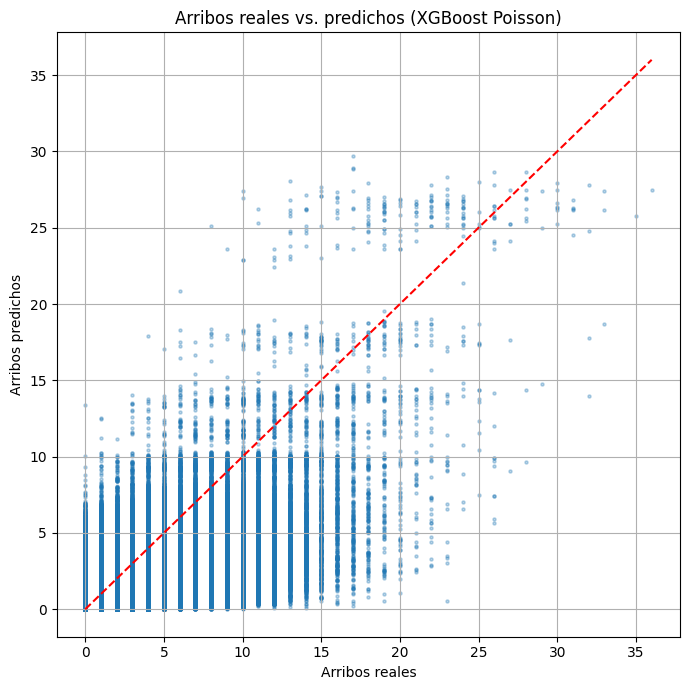

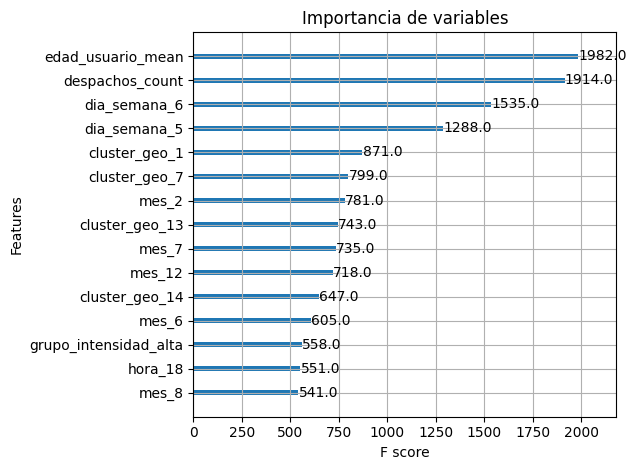

In [ ]:
y_pred = bst.predict(dtrain)  # o sobre otro X_encoded_test
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y, y_pred)
print(f"MAE: {mae:.2f}")
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse:.2f}")
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")

plt.figure(figsize=(7, 7))
plt.scatter(y, y_pred, alpha=0.3, s=5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Arribos reales")
plt.ylabel("Arribos predichos")
plt.title("Arribos reales vs. predichos (XGBoost Poisson)")
plt.grid(True)
plt.tight_layout()
plt.show()

xgb.plot_importance(bst, max_num_features=15)
plt.title("Importancia de variables")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [ ]:
bst = xgb.train(params, dtrain, num_boost_round=100)

In [ ]:
y_pred = bst.predict(dtest)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Evaluación en Test:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")


Evaluación en Test:
MAE: 0.34
RMSE: 0.69
R²: 0.410


In [ ]:
import gc
gc.collect()

0

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain=xgb.DMatrix(X_encoded, label=y),
    num_boost_round=100,
    nfold=5,
    metrics=['poisson-nloglik'],
    seed=42,
    as_pandas=True,
    verbose_eval=False,
    
)

print(cv_results.tail())
cv_results[['train-poisson-nloglik-mean', 'test-poisson-nloglik-mean']].plot(figsize=(10, 5))
plt.title("Poisson-NLogLik: Train vs Test")
plt.xlabel("Ronda de boosting")
plt.ylabel("Poisson-Negative Log-Likelihood")
plt.grid()
plt.show()


MemoryError: Unable to allocate 16.2 GiB for an array with shape (60, 36208773) and data type object

In [ ]:
best_round = cv_results['test-poisson-nloglik-mean'].idxmin()
best_score = cv_results.loc[best_round, 'test-poisson-nloglik-mean']
print(f"Mejor ronda: {best_round} con Poisson-NLogLik promedio en test: {best_score:.4f}")


Mejor ronda: 99 con Poisson-NLogLik promedio en test: 0.5145


In [ ]:
final_model = xgb.train(
    params,
    dtrain=xgb.DMatrix(X_encoded, label=y),
    num_boost_round=best_round
)


In [ ]:
dtest = xgb.DMatrix(X_encoded)  # O nuevos datos con las mismas columnas
y_pred = final_model.predict(dtest)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
poisson_nloglik = -np.mean(y * np.log(y_pred + 1e-6) - y_pred)  # misma fórmula que XGBoost

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Poisson NLogLik (manual): {poisson_nloglik:.4f}")


RMSE: 0.47
MAE: 0.33
R²: 0.4213
Poisson NLogLik (manual): 0.3655


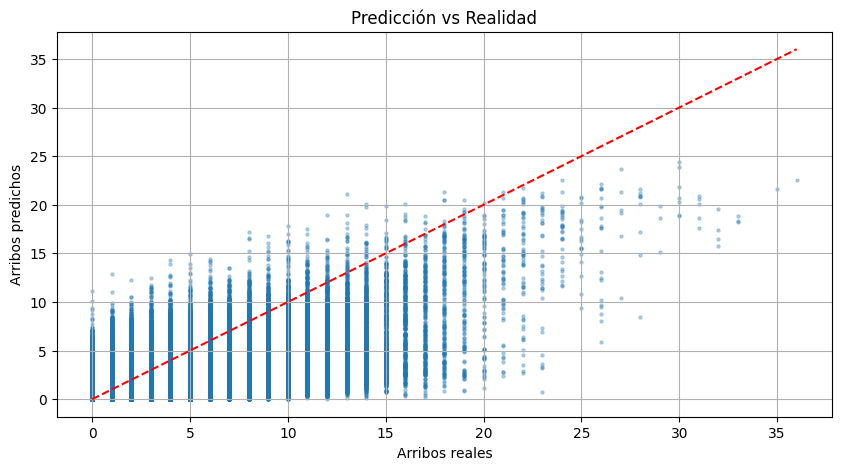

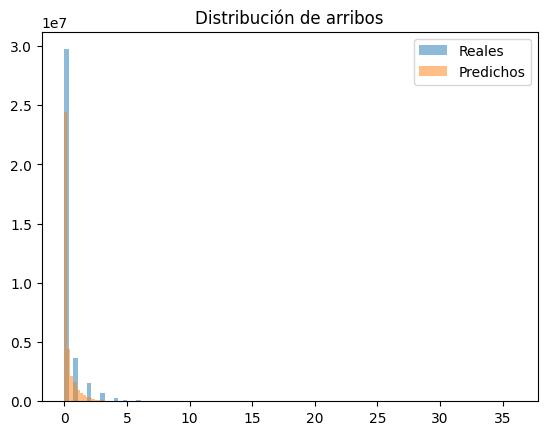

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y, y_pred, alpha=0.3, s=5)
plt.plot([0, y.max()], [0, y.max()], color='red', linestyle='--')
plt.xlabel("Arribos reales")
plt.ylabel("Arribos predichos")
plt.title("Predicción vs Realidad")
plt.grid()
plt.show()

plt.hist(y, bins=100, alpha=0.5, label="Reales")
plt.hist(y_pred, bins=100, alpha=0.5, label="Predichos")
plt.legend()
plt.title("Distribución de arribos")
plt.show()


In [ ]:
y_pred_cero = np.zeros_like(y_test)
print("Evaluación del modelo que predice siempre 0:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_cero):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cero)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_cero):.3f}")

Evaluación del modelo que predice siempre 0:
MAE: 0.33
RMSE: 0.96
R²: -0.132
